<a href="https://colab.research.google.com/github/jakinng/a-PINN/blob/main/diffusion_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Newton's Method
# Adapted from https://jax.quantecon.org/newtons_method.html
# https://wiki.math.ntnu.no/_media/tma4125/2017v/newton.pdf

# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import jax
from jax import numpy as jnp
from IPython.display import HTML # display videos

"""
Computes a root of f using Newton's method, with initial guess x_0

Parameters:
* f : the function to find a root of
* x_0 : the initial guess for a root
* max_iter : the maximum number of iterations
"""
def newton(f, x_0, tol = 1e-5, max_iter = 3):
    df = jax.jacfwd(f) # Jacobian of f
    error = jnp.inf
    e_all = jnp.expand_dims(error, axis = 0) # Error for each iteration
    x_all = jnp.expand_dims(x_0, axis = 0) # Value for each iteration
    n_iter = 0
    while error > tol and n_iter < max_iter:
        n_iter += 1
        x = x_all[n_iter - 1]
        dfx = df(x)
        # print(f"{jnp.linalg.matrix_rank(dfx)=}")
        if dfx.shape == (): # The problem is 1-dimensional
            # x_n = x - jnp.linalg.lstsq(jnp.array(dfx).reshape(1, 1), jnp.array(f(x)).reshape(1, ))[0]
            x_all = jnp.append(x_all, jnp.expand_dims((x - f(x) / dfx), axis = 0), axis = 0) # Newton iteration
        else:
            # x_n = x - jnp.linalg.pinv(df(x)) @ f(x)
            # x_n = x - jnp.linalg.solve(df(x), f(x))
            print(f"{jnp.linalg.lstsq(dfx, f(x))[0]=}")
            x_n = x - jnp.linalg.lstsq(dfx, f(x))[0] # x_n = x - JF(x)^{-1}f(x)
            x_all = jnp.append(x_all, x_n[None, :], axis = 0)
        # error = jnp.linalg.norm(x_all[n_iter] - x_all[n_iter - 1]) / jnp.linalg.norm(x_all[n_iter - 1])
        error = jnp.linalg.norm(f(x_all[n_iter]))
        # print(f"{error=}")
        e_all = jnp.append(e_all, jnp.expand_dims(error, axis = 0), axis = 0)
    else:
        return x_all, n_iter, e_all

def plot_function_1d(f, range, label = '$f(x)$', x_label = '$x$', y_label = '$f(x)$', show = True):
    n = 100
    fontsize = 12
    x = jnp.linspace(range[0], range[1], n)
    fig, ax = plt.subplots()
    ax.plot(x, f(x), label = label)
    ax.set_xlabel(x_label, fontsize = fontsize)
    ax.set_ylabel(y_label, fontsize = fontsize)
    ax.axhline(color = 'black', linestyle = '--', linewidth = 1)
    ax.legend(fontsize = fontsize)
    if show:
        plt.show()
    return fig, ax

def newton_1d_example():
    # f = lambda x: jnp.sin(4 * (x - 1/4)) + x + x ** 20 - 3
    f = lambda x: x ** 2 - 3 * x -3
    x_0 = -3.0
    root, n_iter, error = newton(f, x_0 = x_0)
    fig, ax = plot_function_1d(f, range = (-5, 5), show = False)
    # print(root[0]))
    ax.plot(root, f(root), marker = 'x', color = 'red', label = f"root: {root[-1]:.4f}", markersize = 10)
    ax.legend()
    plt.show()
    print(f"Number of iterations starting from x_0 = {x_0}: {n_iter}")
    print(f"{root=}")
    print(f"{error=}")
    plt.close()

def newton_2d_example(): # from https://wiki.math.ntnu.no/_media/tma4125/2017v/newton.pdf
    def f(x):
        return jnp.array([x[0] * jnp.exp(x[1]) - 1, -x[0]**2 + x[1] - 1])
    x_0 = jnp.array([0.1, 0.1])
    print(f(x_0))
    x, n_iter, e_all = newton(f, x_0, tol = 10e-7, max_iter = 100)
    print(f"{x=}", n_iter)
    print(f(x))

# newton_1d_example()
newton_2d_example()

In [ ]:
def plot_data(data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    vmin = jnp.min(data) if vmin is None else vmin
    vmax = jnp.max(data) if vmax is None else vmax
    if X is None or Y is None:
        p = ax.pcolormesh(data, vmin = vmin, vmax = vmax)
    else:
        p = ax.pcolormesh(X, Y, data, vmin = vmin, vmax = vmax)
    cbar = plt.colorbar(p, ax = ax)
    if show:
        plt.show()
    return fig, plt, p

class Solver():
    def __init__(self, N, N_t, dt, bounds, seed, ic, bc, folder = "/content/drive/MyDrive/superUROP", equation = "adv-diff", initializer = None):
        self.N = N
        self.N_t = N_t
        self.dt = dt
        self.bounds = bounds
        self.L, self.dx, self.x, self.y, self.X, self.Y = self.domain(N, bounds)
        self.seed = seed
        self.key = jax.random.PRNGKey(seed)
        self.u = self.initial_condition(ic, bc)
        self.ic = ic
        self.bc = bc
        self.folder = folder
        self.equation = equation
        self.test_name = self.test_name(equation)
        self.initializer = lambda x: x.flatten() if initializer is None else initializer

    """
    Helper function returning a plot of the data
    """
    def plot_data(self, data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
        return plot_data(data, title = title, X = self.X, Y = self.Y)

    """
    Helper function returning u with the boundaries set to 0
    """
    def dirichlet(self, u):
        u_top = 0.0
        u_left = 0.0
        u_bottom = 0.0
        u_right = 0.0
        u = u.at[-1, :].set(u_top)
        u = u.at[0, :].set(u_bottom)
        u = u.at[:, 0].set(u_left)
        u = u.at[:, -1].set(u_right)
        return u

    def diffusion_coefficient(self, u):
        # x_reshape = x.reshape(self.N, self.N)
        grad_y, grad_x = jnp.gradient(u)
        grad_norm2 = jnp.linalg.norm(jnp.array([grad_x, grad_y]), axis = 0) ** 2 # Norm-squared of the gradient of solution
        d = jnp.exp(-1 * grad_norm2) # Diffusion coefficient
        # min = jnp.min(d)
        # max = jnp.max(d)
        # return 0
        return d

    def advection_velocity(self):
        v_x = 1
        v_y = 4
        return v_x, v_y

    def test_name(self, equation):
        return f"{equation}_{self.ic}_{self.bc}_{self.N}x{self.N}_{self.seed}_dt{self.dt}"

    def domain(self, N, bounds):
        L = bounds[1] - bounds[0]
        x = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
        y = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
        X, Y = jnp.meshgrid(x, y)
        dx = L / N
        return L, dx, x, y, X, Y

    def initial_condition(self, ic, bc):
        # Initialize the solution grid of u(k, i, j)
        u = jnp.zeros((self.N_t, self.N, self.N))
        noise = jax.random.normal(key = self.key, shape = u[0].shape) # Gaussian noise
        # Set the initial condition
        if ic == 1:
            u = u.at[0, self.N // 4 : 3 * self.N // 4, self.N // 4 : 3 * self.N // 4].set(1)
            noise_level = 0.1

        elif ic == 2:
            coeffs = jax.random.normal(key = self.key, shape = (5, 3))
            def poly(x, y):
                omegas = jnp.geomspace(0.5, 2, coeffs.shape[0])
                return jnp.sum(coeffs[:, 0] * jnp.cos(x * omegas + coeffs[:, 1]) * jnp.cos(y * omegas + coeffs[:, 2]))
            v = jax.vmap(jax.vmap(poly))(self.X, self.Y)
            scale = 2
            v = scale * (2 * v - jnp.min(v) - jnp.max(v)) / (jnp.max(v) - jnp.min(v)) # rescale to range -10 to 10

            # clip at threshold and rescale to (-1, 1)
            threshold = 20
            v = jnp.clip(threshold * v, -scale, scale)
            u = u.at[0].set(v)

            # add noise so DF is not NAN
            noise_level = 0.4
        elif ic == 3:
            u = u.at[0, :, :].set(100 * (1 - ((self.X - jnp.pi) / jnp.pi) ** 2) * (1 - ((self.Y - jnp.pi) / jnp.pi) ** 2))
            noise_level = 10

        elif ic == 4:
            u = u.at[0].set(jnp.exp(- ((self.X - (self.bounds[1] - self.bounds[0]) / 2) ** 2 + (self.Y - (self.bounds[1] - self.bounds[0]) / 2) ** 2)))
            noise_level = 0.1

        # Set the boundary conditions
        u = u.at[0].set(u[0] + noise_level * noise)
        match bc:
            case "dirichlet":
                u = u.at[0].set(self.dirichlet(u[0]))
            case "neumann":
                u = u.at[0, (self.N - 1):, :].set(u[0, self.N - 2 : self.N - 1, :])
                u = u.at[0, :, :1].set(u[0, :, 1:2])
                u = u.at[0, :1, :].set(u[0, 1:2, :])
                u = u.at[0, :, (self.N - 1):].set(u[0, :, self.N - 2:self.N - 1])
            case "torus":
                pass
        return u

    def F(self, u):
        u = u.reshape(self.N, self.N)

        v_x, v_y = self.advection_velocity()
        if v_x > 0:
            # Dirichlet boundary conditions
            # Multiply by velocity (https://iopscience.iop.org/article/10.1088/1742-6596/1180/1/012009/pdf)
            pad_x = jnp.pad(u * v_x, pad_width = ((0, 0), (1, 0)))
        elif v_x <= 0:
            pad_x = jnp.pad(u * v_x, pad_width = ((0, 0), (0, 1))) # Dirichlet boundary conditions
        if v_y > 0:
            pad_y = jnp.pad(u * v_y, pad_width = ((1, 0), (0, 0)))
        elif v_y <= 0:
            pad_y = jnp.pad(u * v_y, pad_width = ((0, 1), (0, 0)))
        grad_vx = (pad_x[:, 1:] - pad_x[:, :-1]) / self.dx
        grad_vy = (pad_y[1:, :] - pad_y[:-1, :]) / self.dx
        op = -1 * (grad_vx + grad_vy)

        d = self.diffusion_coefficient(u)
        lap_kernel = 1 / (self.dx ** 2) * jnp.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        op += d * 1 * jax.scipy.signal.convolve2d(u, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
        if self.bc == "dirichlet":
            # Set boundaries to zero
            op = self.dirichlet(op)
        return op.flatten()
        # elif self.bc == "torus":
        #         op = d * self.dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "wrap", fillvalue = 0)

    def finite_difference(self, diffusion_coefficient = None):
        v_x, v_y = self.advection_velocity()
        C = jnp.abs(v_x * self.dt / self.dx) + jnp.abs(v_y * self.dt / self.dx)
        print(f"The Courant number at x = 0, y = 0 is {C}. Stable if C <= 1.")
        for k in range(self.N_t - 1):
            op = self.F(self.u[k]).reshape(self.N, self.N)
            self.u = self.u.at[k + 1].set(self.u[k] + dt * op) # Add delta u term
            self.u = self.u.at[k + 1].set(self.dirichlet(self.u[k + 1]))
        filename = f"{self.folder}/{self.test_name}"
        jnp.save(filename, self.u)
        self.test_name += "finite_diff"

    def backward_euler(self, max_newton_iter = 10):
        for k in range(self.N_t - 1):
            x_0 = initializer(self.u[k])
            # Find root x satisfying x - u[k] = dt * (op(x)) and set it to be u[k + 1]
            x_all, n_iter, e_all = newton(f = lambda x: x - self.u[k].flatten() - self.dt * self.F(x), x_0 = x_0, max_iter = max_newton_iter)
            print(f"{e_all=}")
            self.u = self.u.at[k + 1].set(x_all[-1].reshape(self.N, self.N))
        self.test_name += "newton"
    def animate_solution(self, u, folder = None, test_name = None):
        folder = self.folder if folder is None else folder
        test_name = self.test_name if test_name is None else test_name
        fig, plt, p = self.plot_data(u[0], title = f"Solution at t = {0 * self.dt:.3f}", vmin = jnp.min(u), vmax = jnp.max(u))

        def animate(k):
            p.set_array(u[k])
            p.set_clim(jnp.min(u), jnp.max(u))
            plt.title(f"Solution at t = {k * self.dt:.3f}")

        filename = f"{folder}/{test_name}"
        anim = animation.FuncAnimation(fig, animate, frames = self.N_t, repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 20)
        anim.save(f"{filename}.mp4", writer = FFwriter, dpi = 300)
        return anim

N = 32
N_t = 10
bounds = jnp.array([0, 2 * jnp.pi])
seed = 1324
ic = 4
bc = "dirichlet"
dt = 0.004
folder = "/content/drive/MyDrive/superUROP/2024-03-01"
max_newton_iter = 100
initializer = lambda x: x.flatten()
solver = Solver(N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer)
solver.finite_difference()#diffusion_coefficient = lambda x: 0)
solver.backward_euler(max_newton_iter = max_newton_iter)
print(f"Solved!")
print(solver.u.shape)
solver.plot_data(solver.u[0], title = "at time 0", show = True)
solver.plot_data(solver.u[-1], title = "at last time", show = True)
anim = solver.animate_solution(solver.u)

HTML(anim.to_html5_video())
# solver.plot_data(solver.F(solver.u[0]).reshape(solver.N, solver.N), show = True)

The Courant number at x = 0, y = 0 is 0.10185916721820831. Stable if C <= 1.
jnp.linalg.matrix_rank(dfx)=Array(1024, dtype=int32)
jnp.linalg.lstsq(dfx, f(x))[0]=Array([ 0.0000000e+00, -2.2513111e-08,  1.4848274e-08, ...,
        2.8937967e-08,  6.3772532e-08,  0.0000000e+00], dtype=float32)
error=Array(0.00618883, dtype=float32)
jnp.linalg.matrix_rank(dfx)=Array(1024, dtype=int32)
jnp.linalg.lstsq(dfx, f(x))[0]=Array([ 0.0000000e+00,  2.2352099e-08, -1.5203652e-08, ...,
       -2.9055721e-08, -6.3583748e-08,  0.0000000e+00], dtype=float32)
error=Array(3.397745e-07, dtype=float32)
e_all=Array([          inf, 6.1888346e-03, 3.3977449e-07], dtype=float32)
jnp.linalg.matrix_rank(dfx)=Array(1024, dtype=int32)
jnp.linalg.lstsq(dfx, f(x))[0]=Array([ 0.0000000e+00, -3.4399741e-09,  1.1713679e-08, ...,
       -2.8600512e-08, -2.5036071e-08,  0.0000000e+00], dtype=float32)
error=Array(0.00151178, dtype=float32)
jnp.linalg.matrix_rank(dfx)=Array(1024, dtype=int32)
jnp.linalg.lstsq(dfx, f(x))[0]=A

The Courant number is 1.0. Stable if C <= 1.


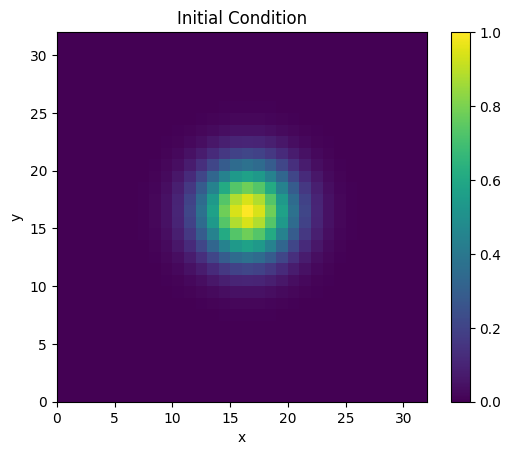

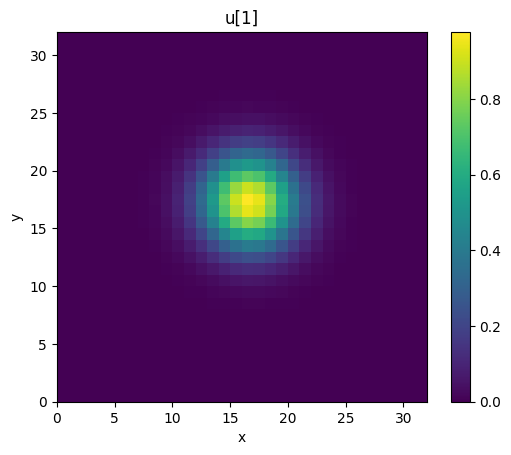

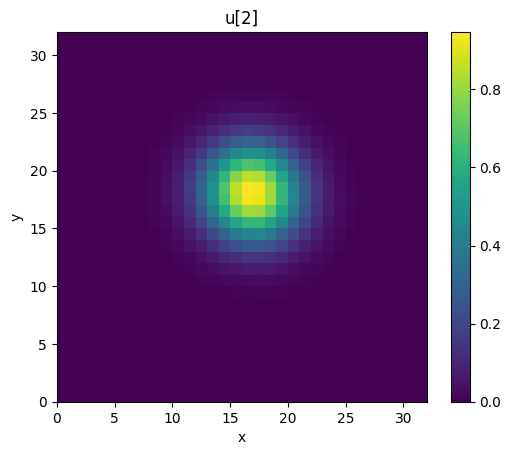

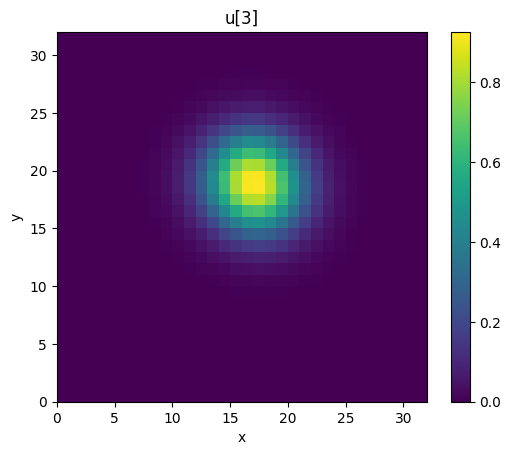

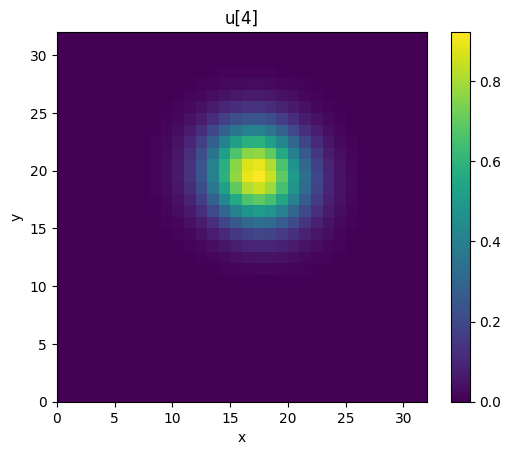

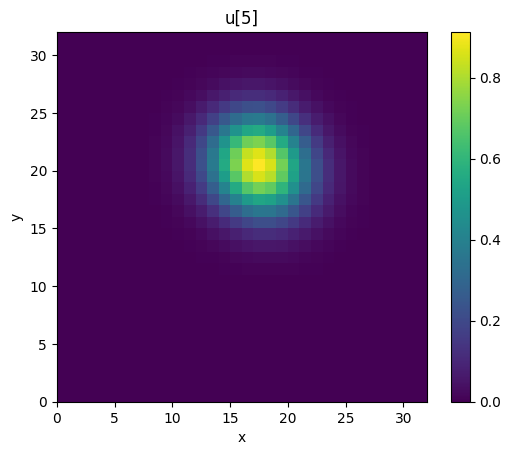

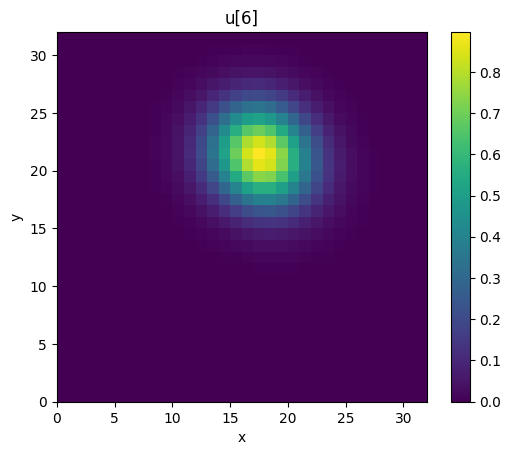

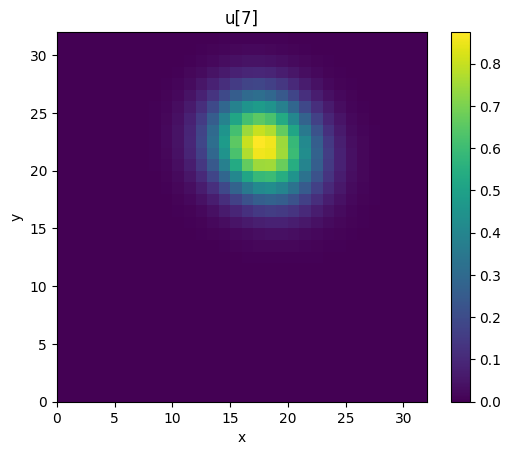

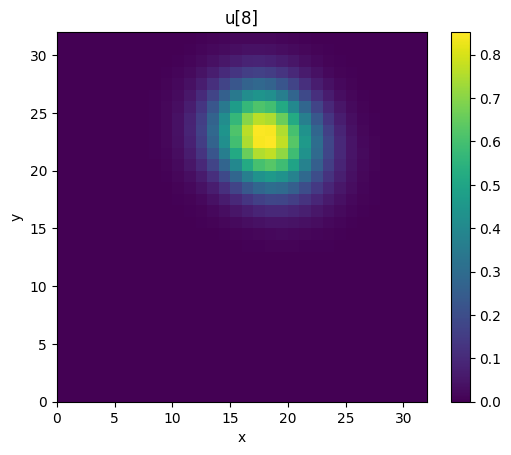

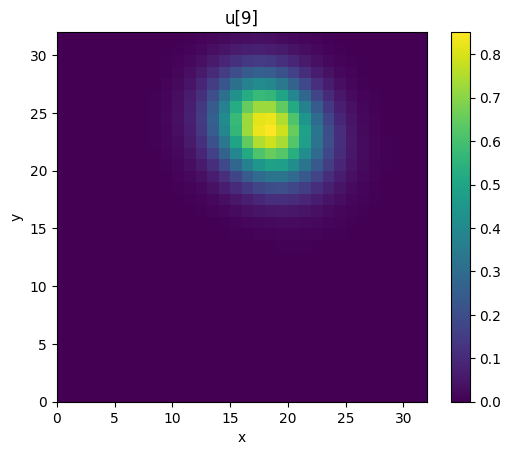

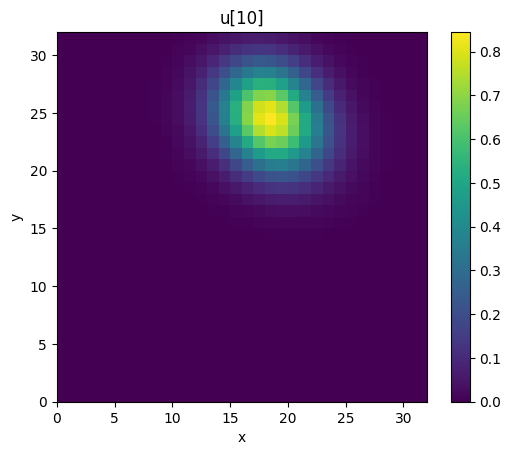

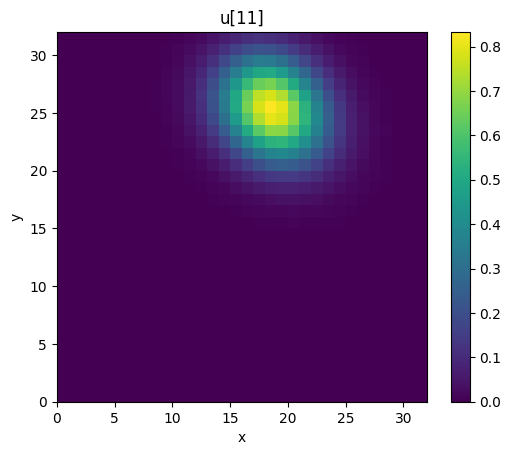

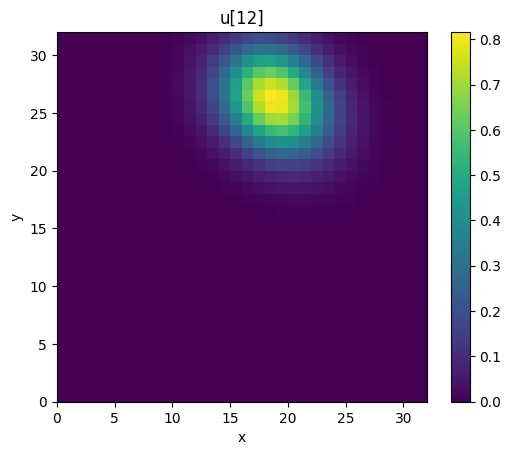

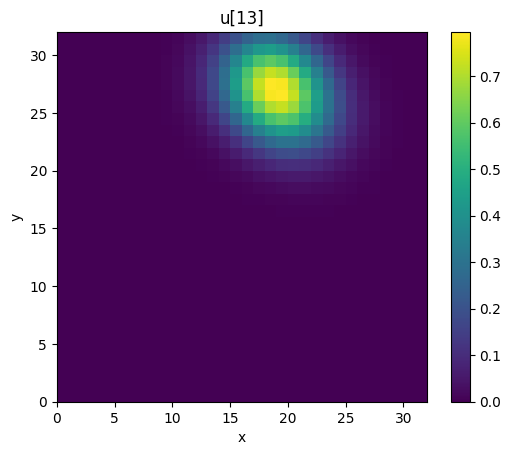

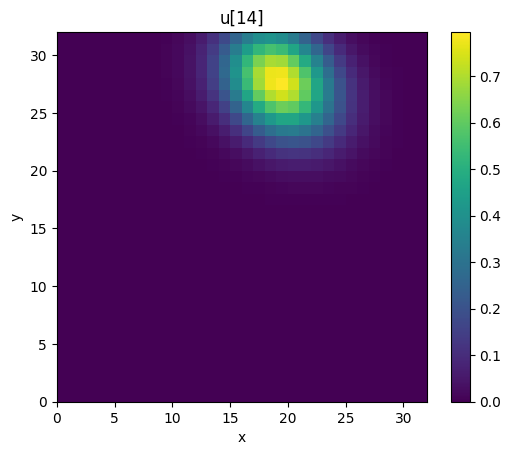

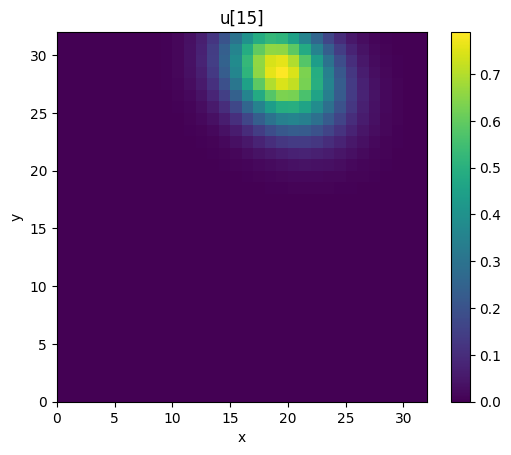

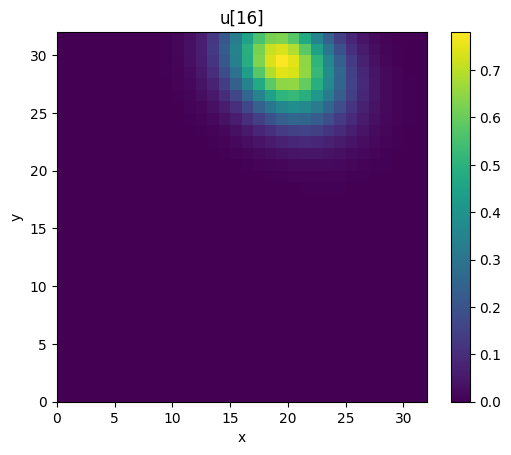

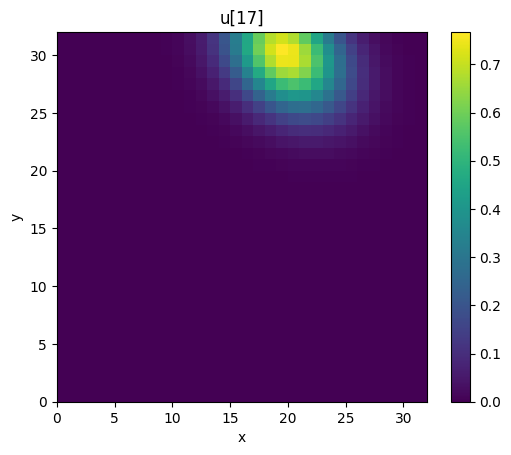

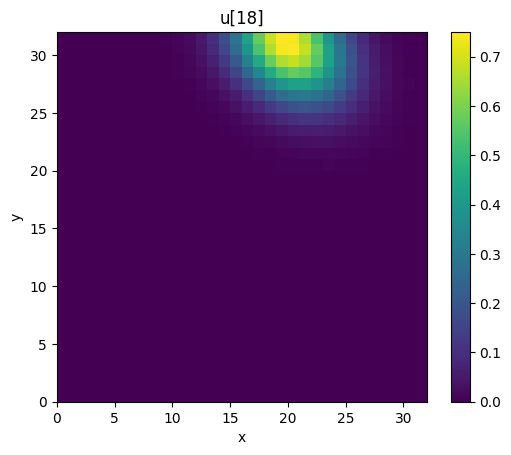

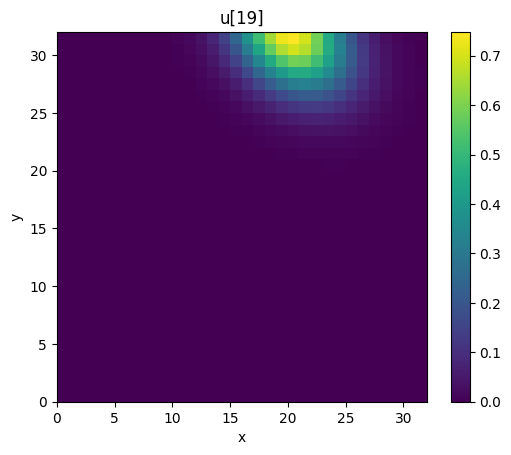

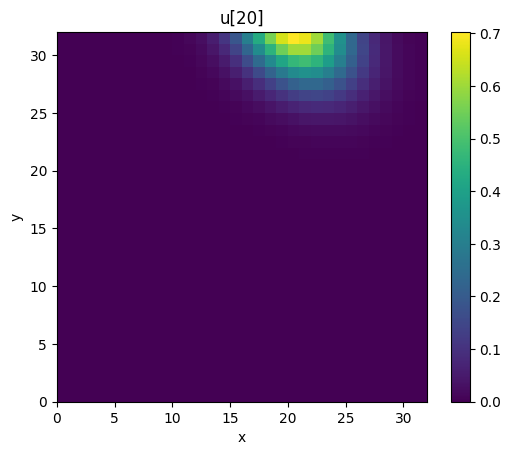

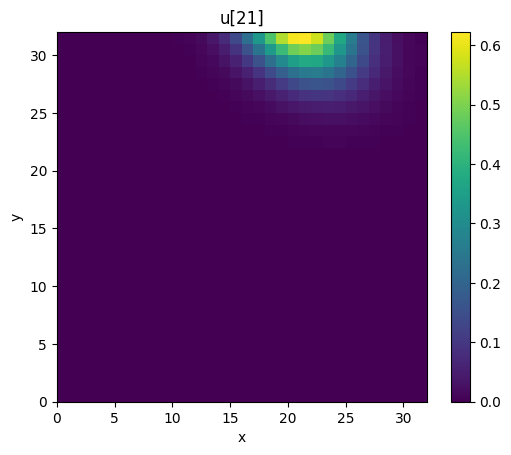

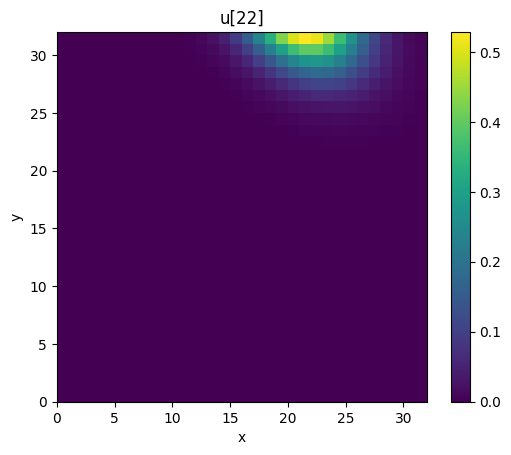

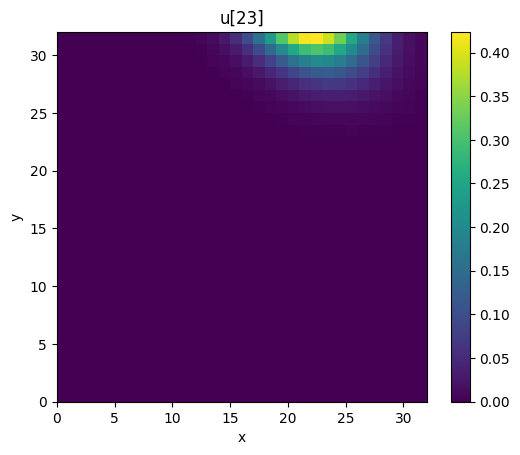

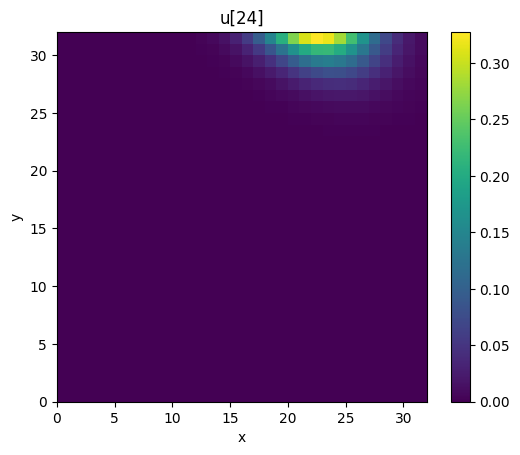

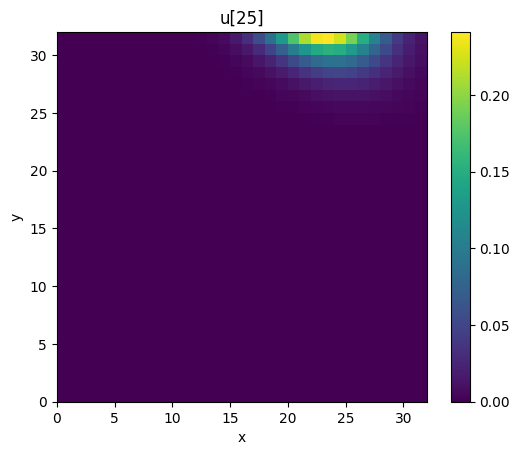

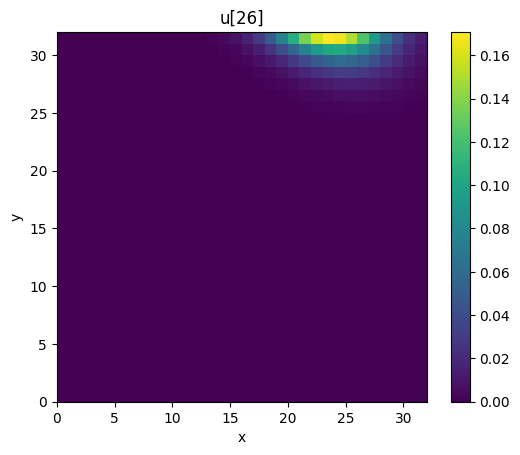

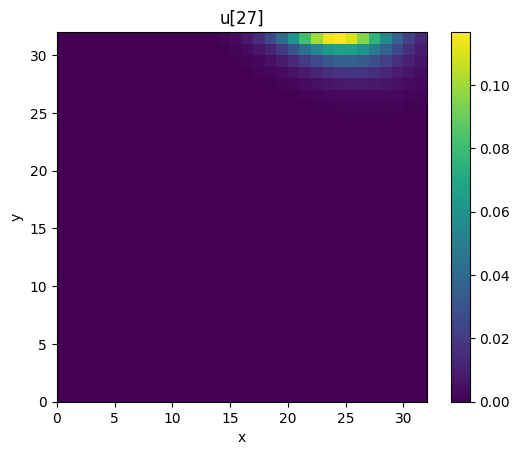

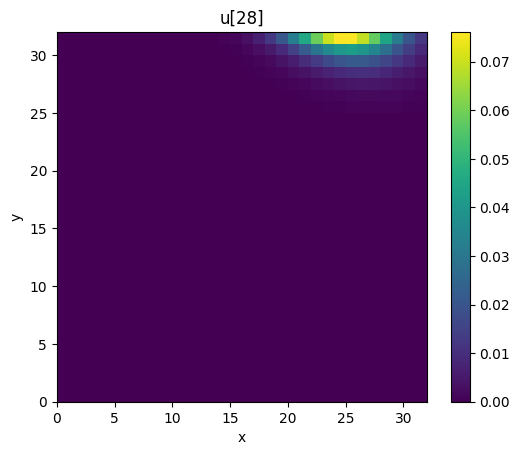

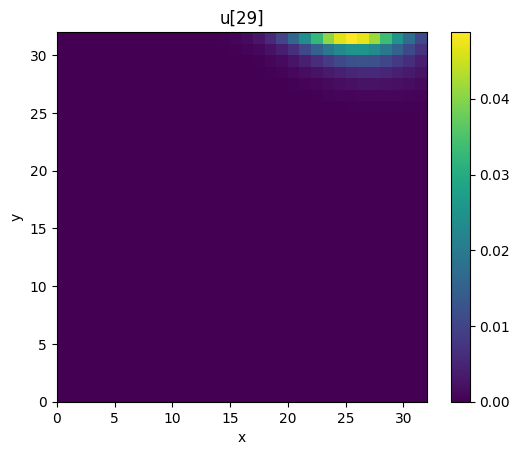

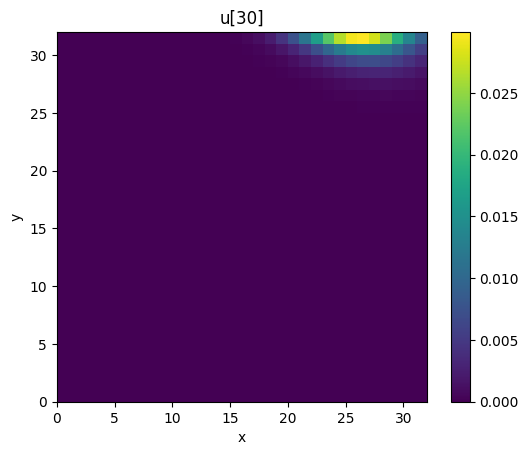

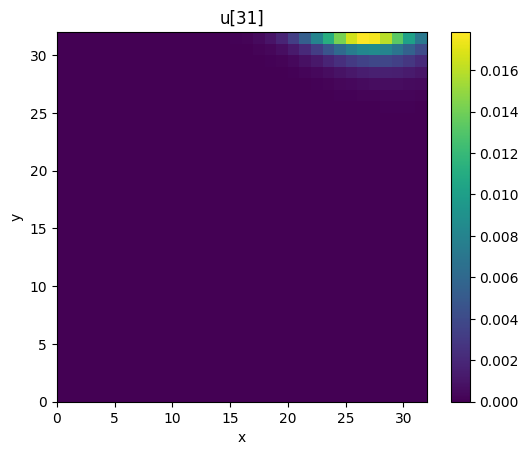

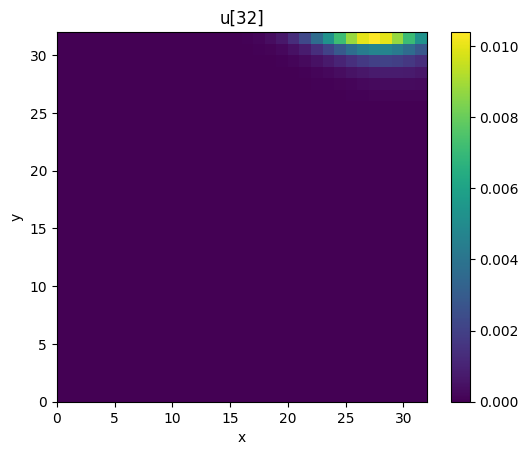

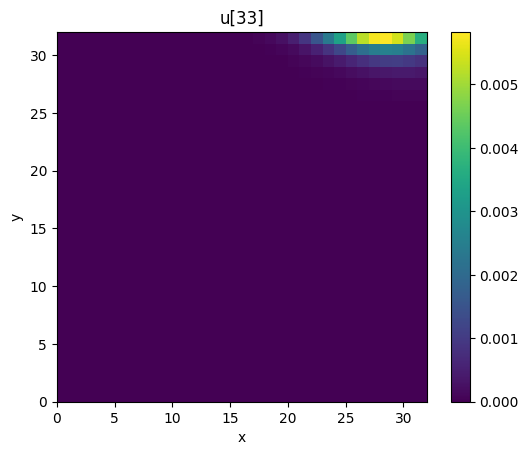

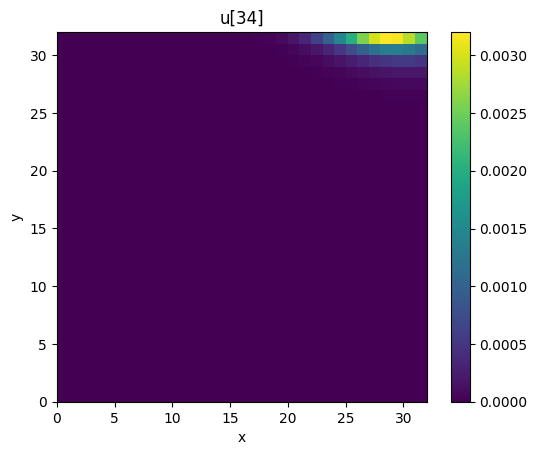

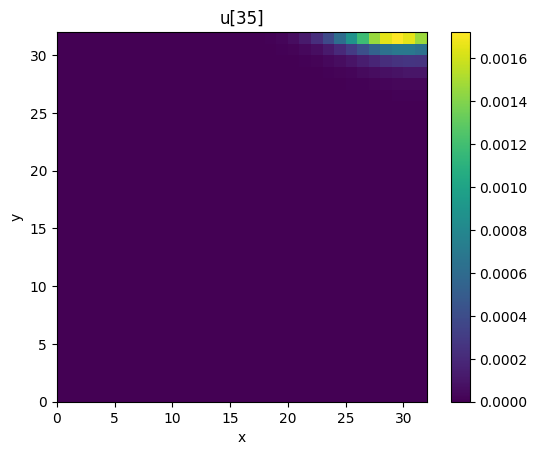

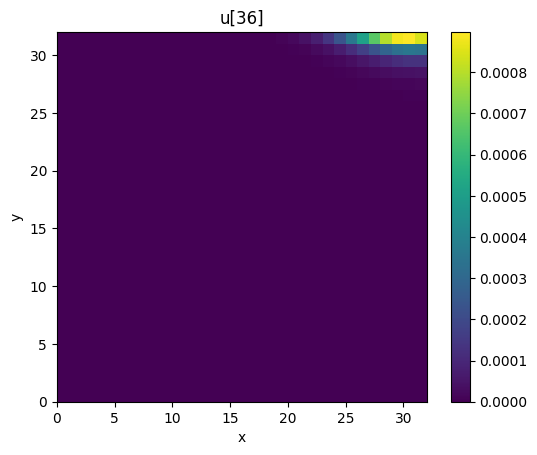

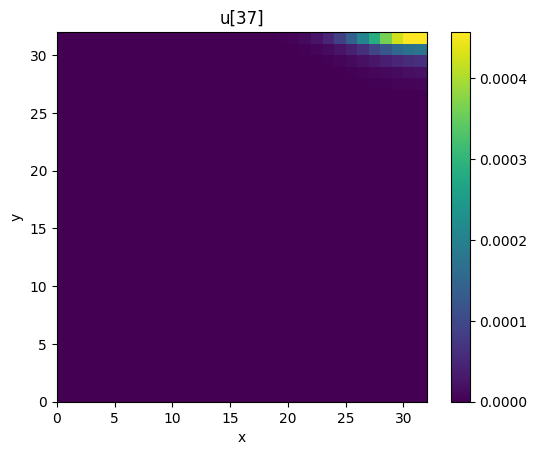

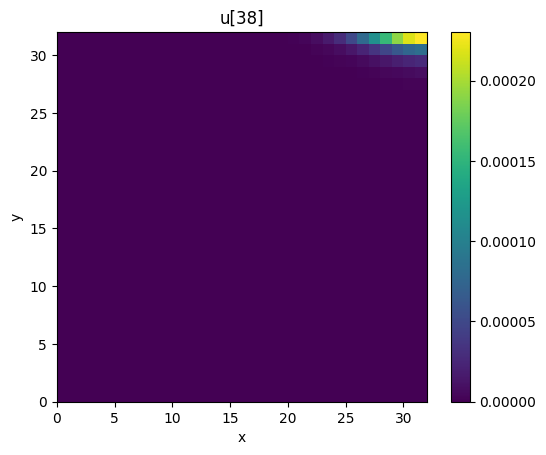

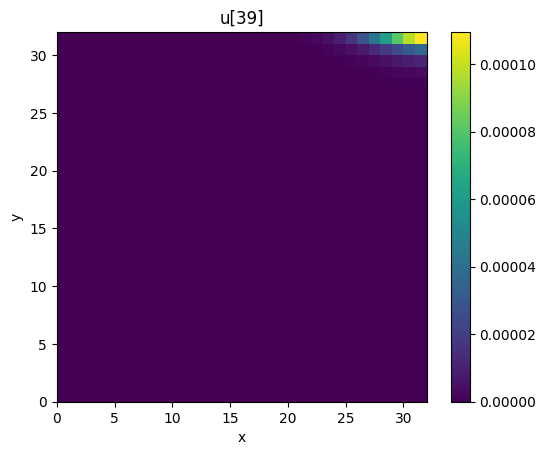

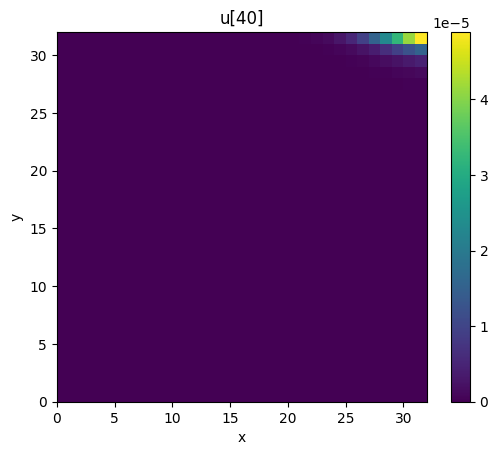

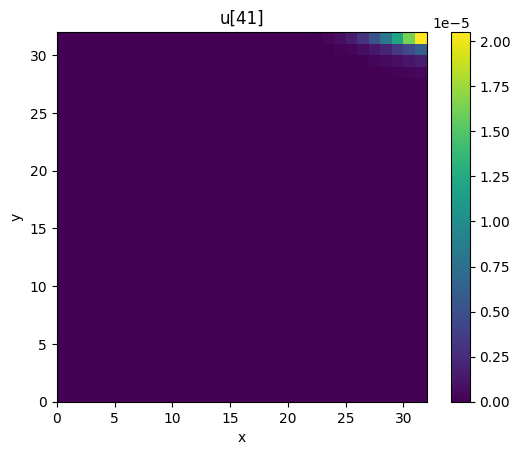

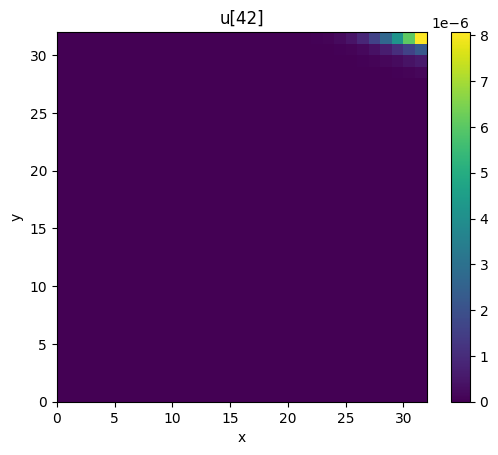

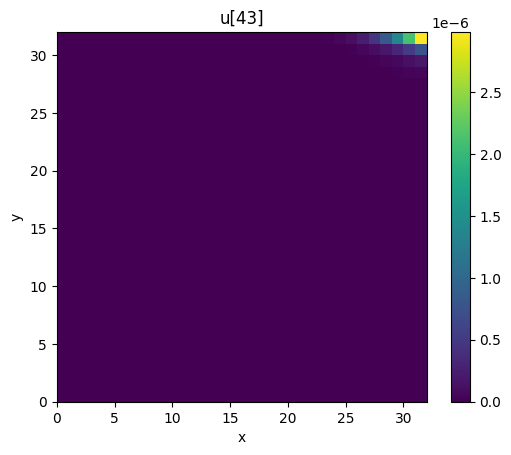

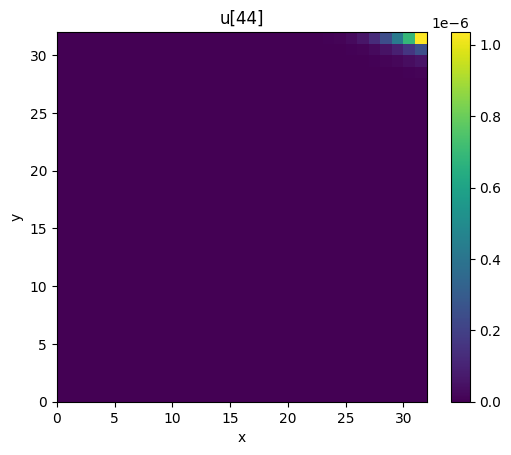

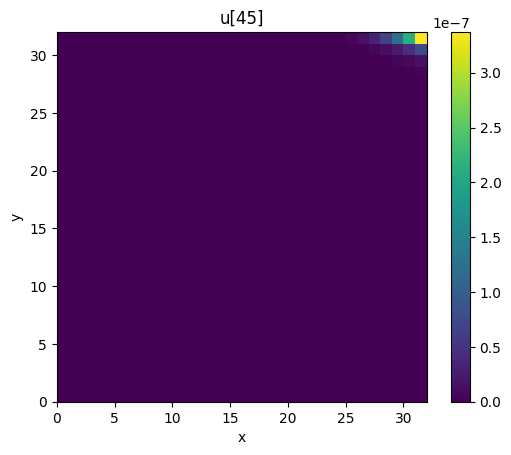

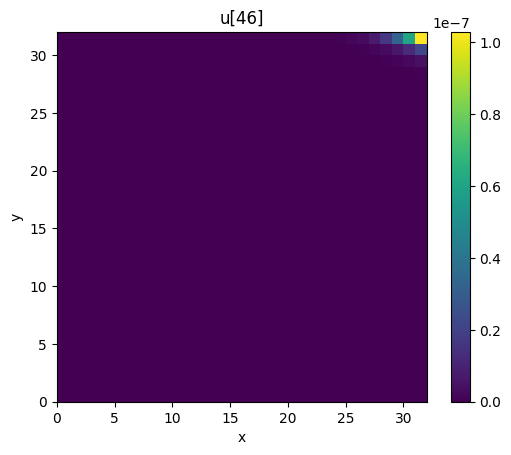

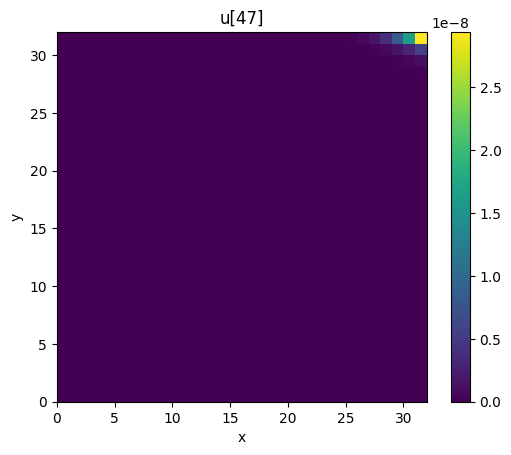

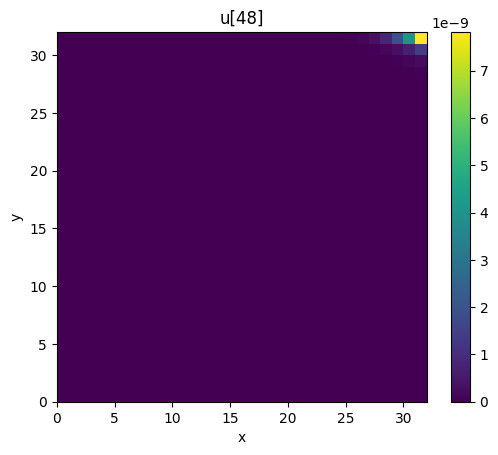

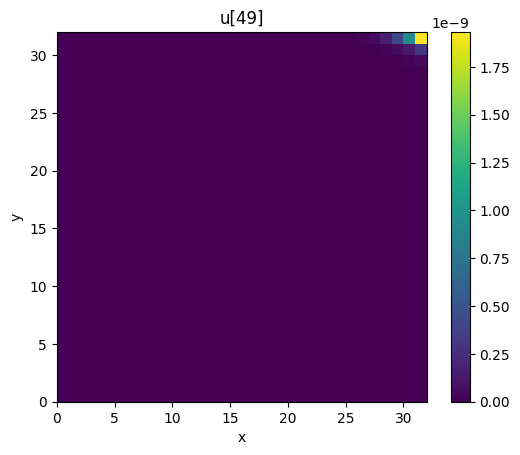

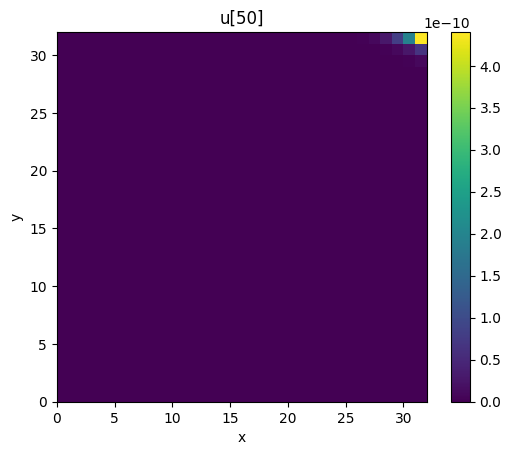

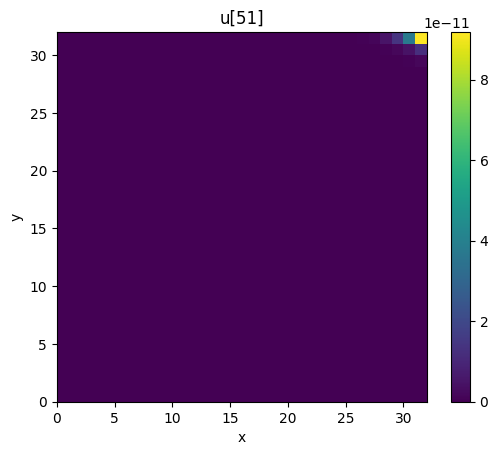

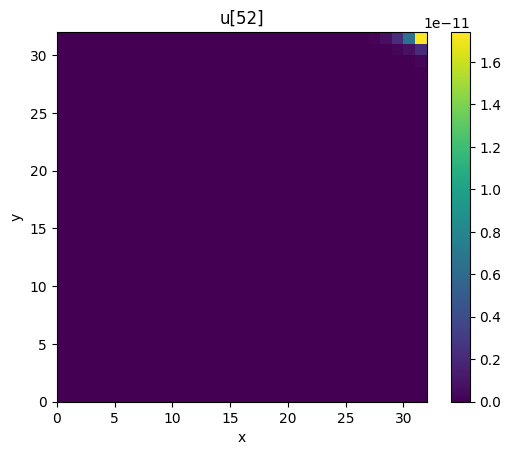

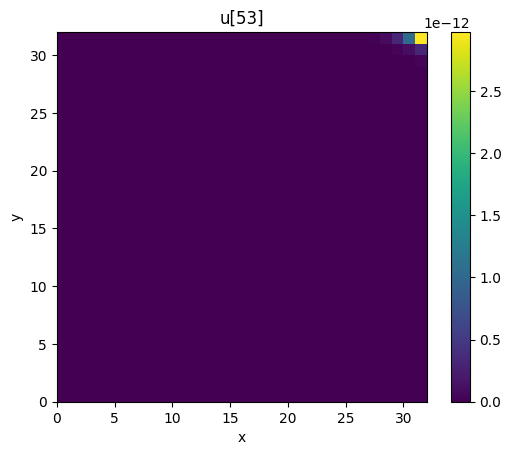

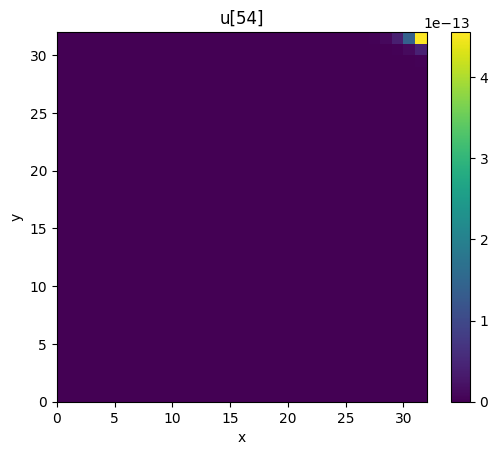

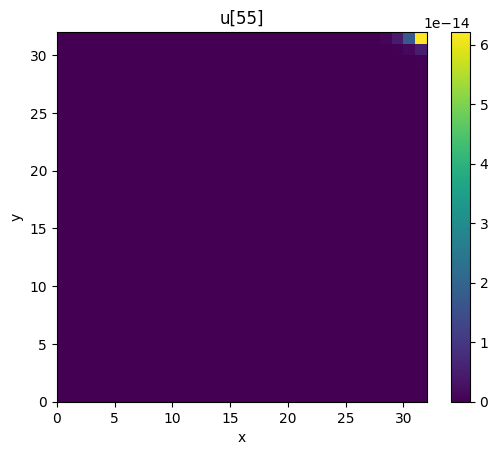

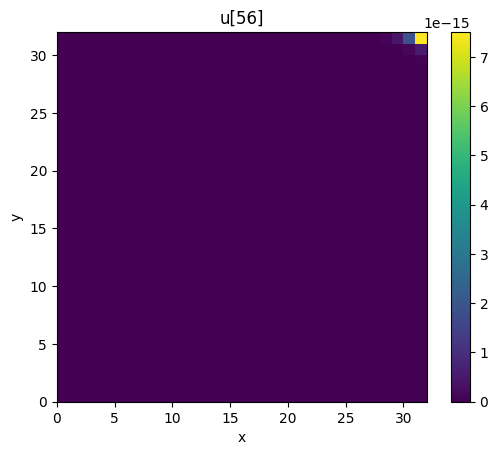

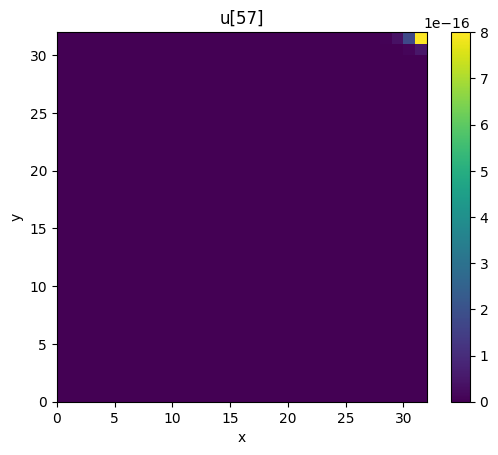

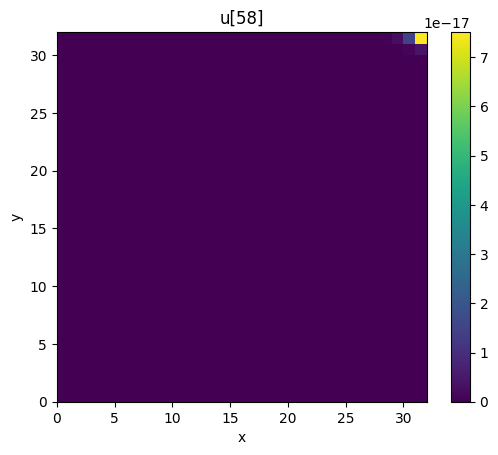

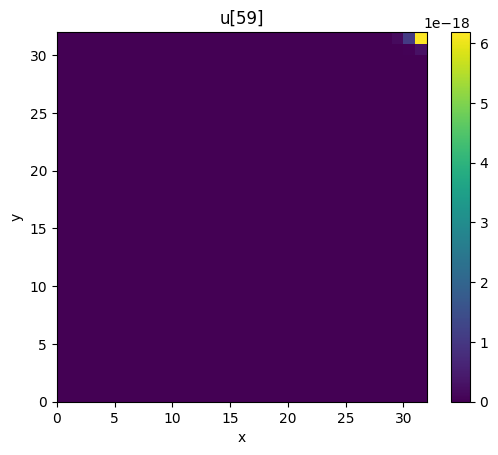

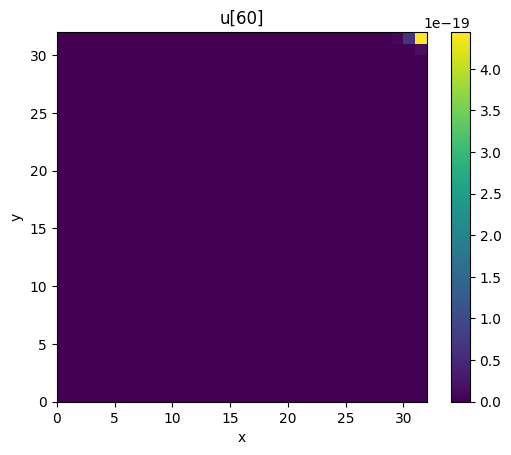

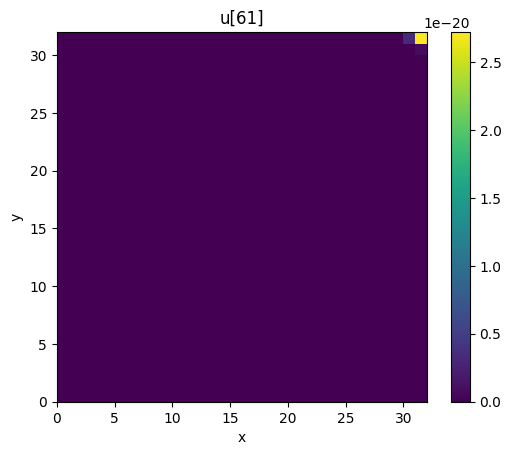

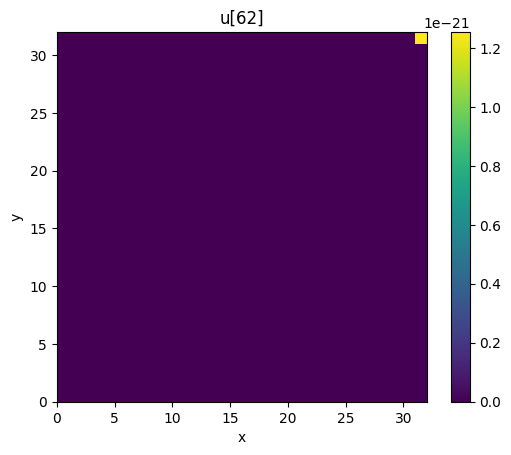

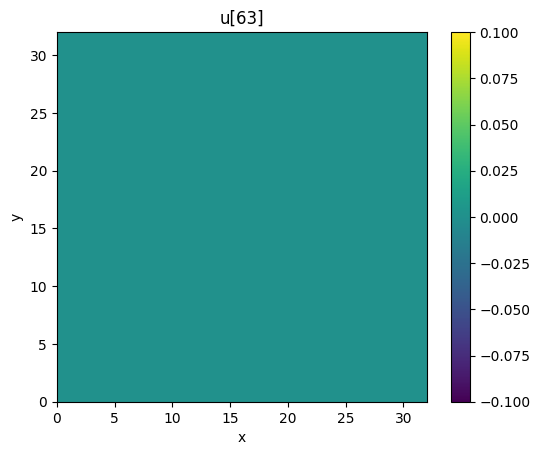

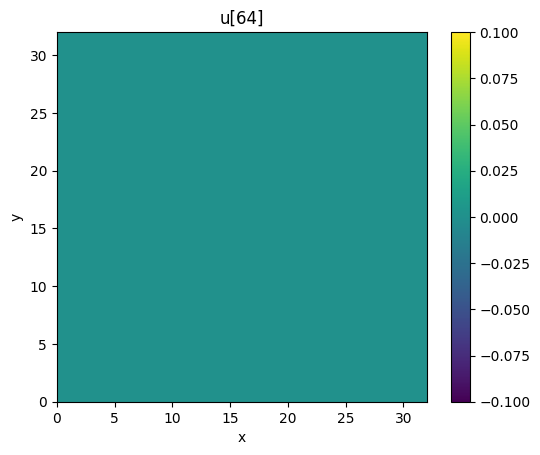

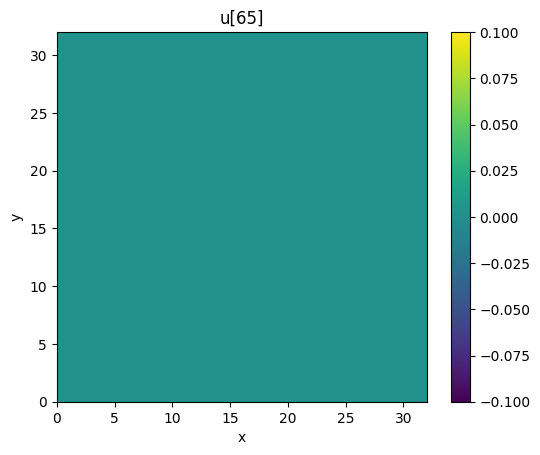

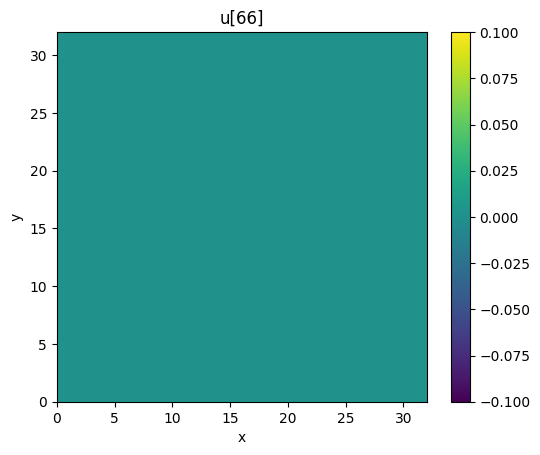

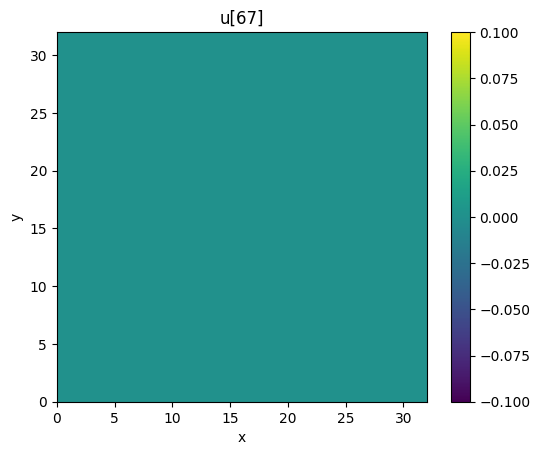

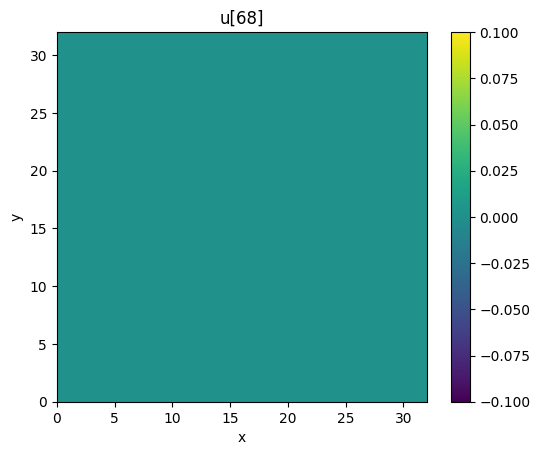

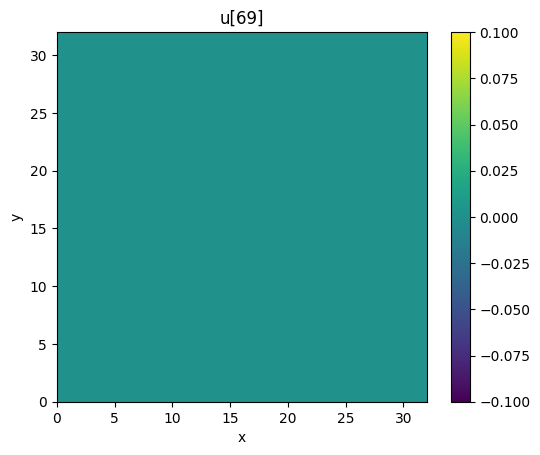

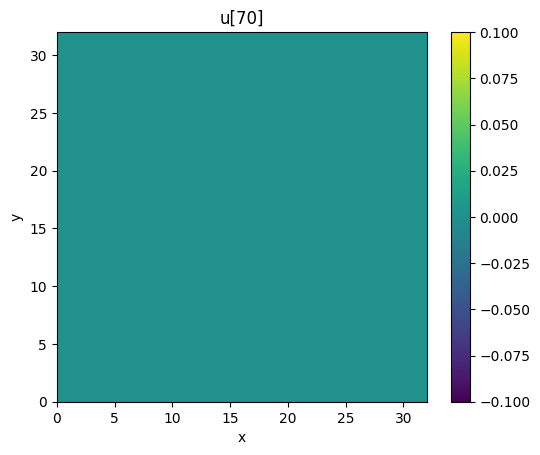

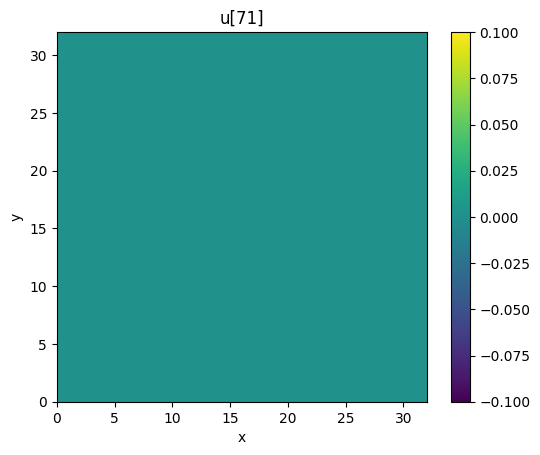

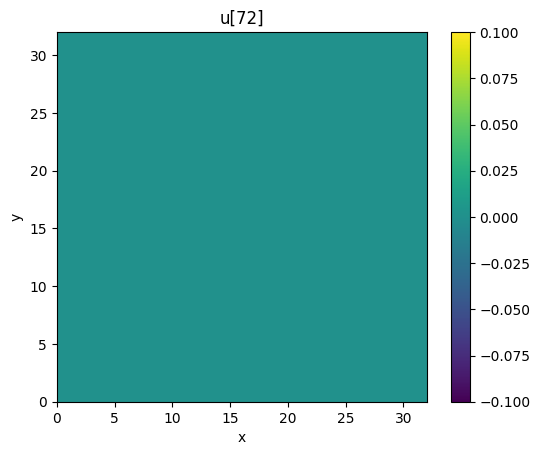

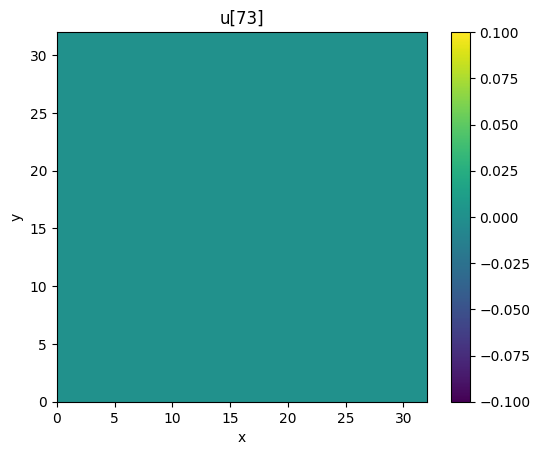

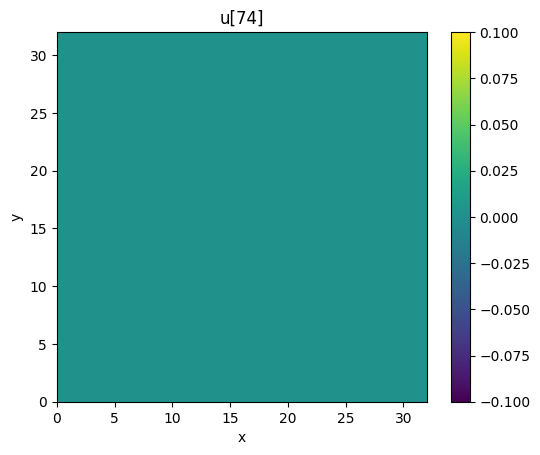

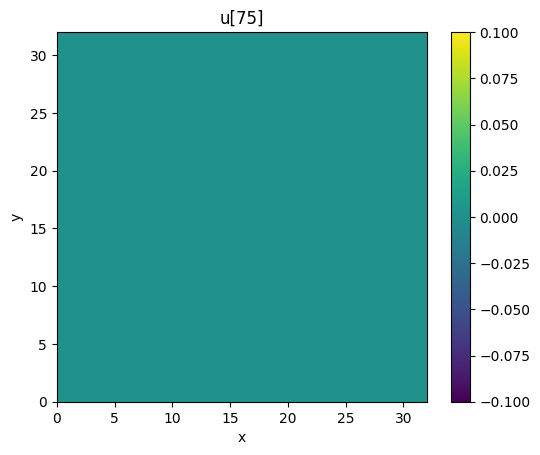

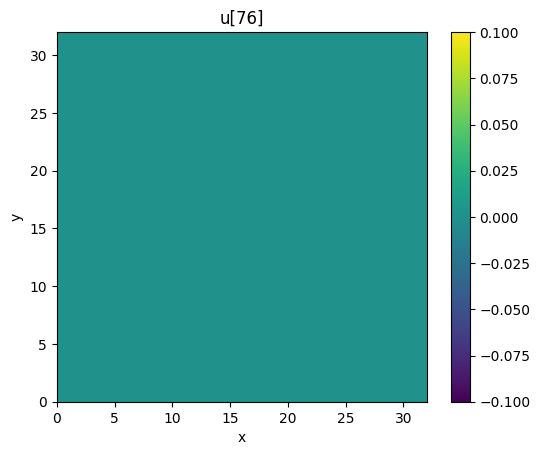

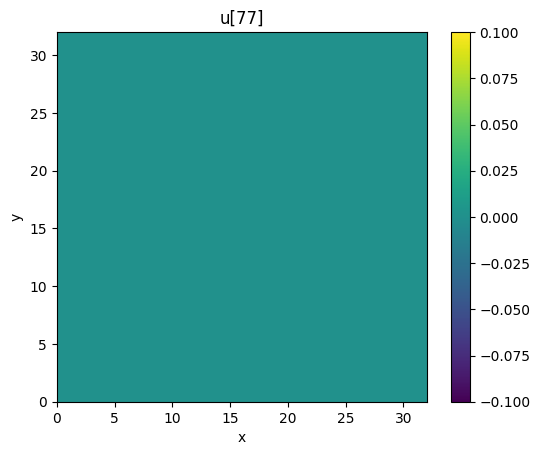

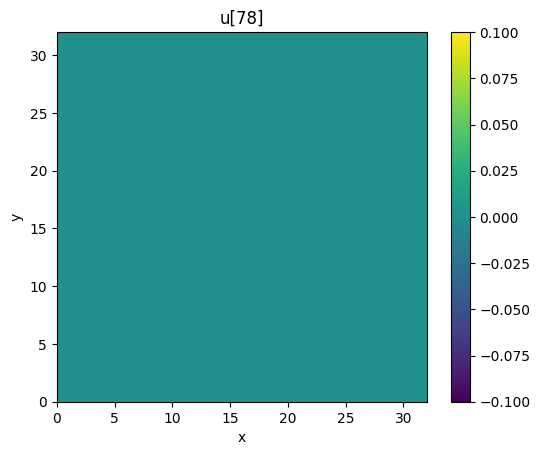

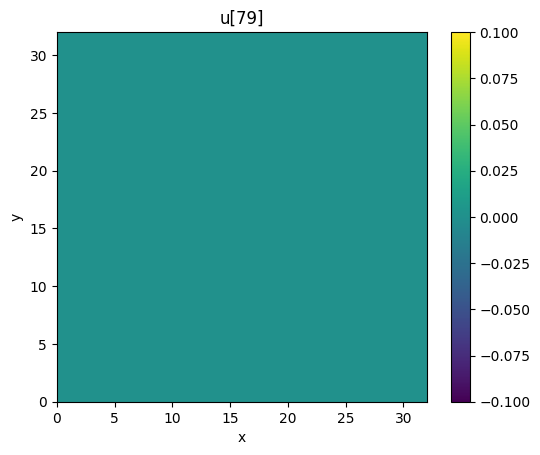

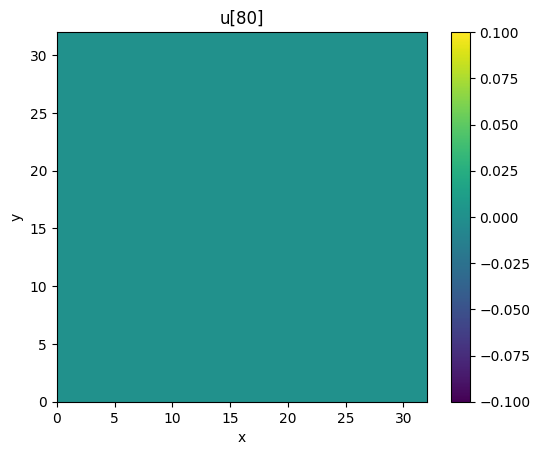

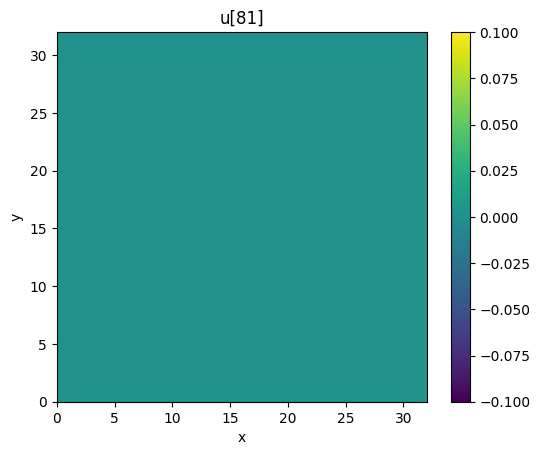

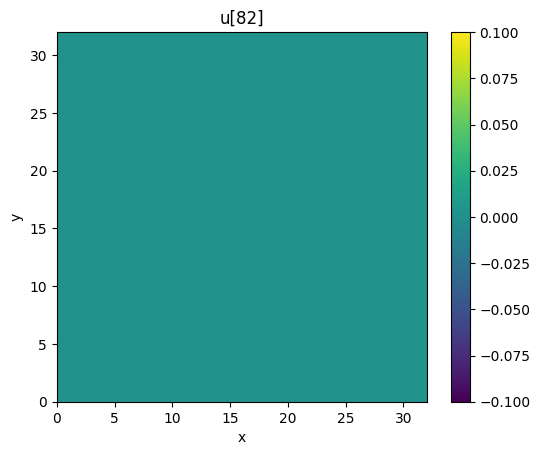

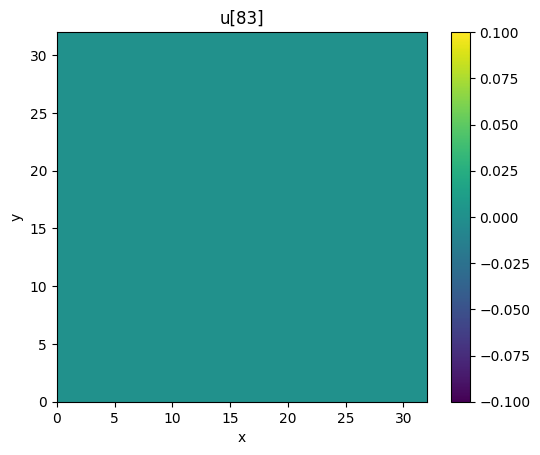

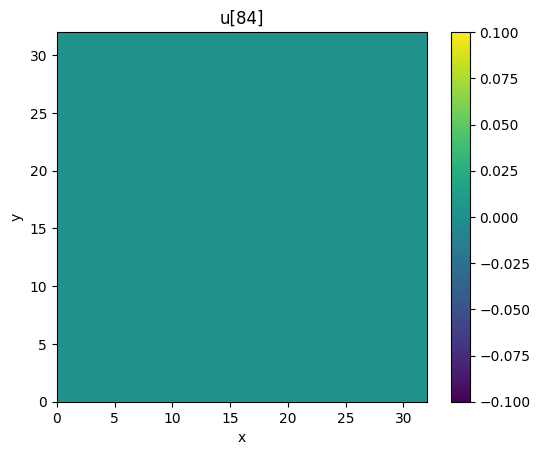

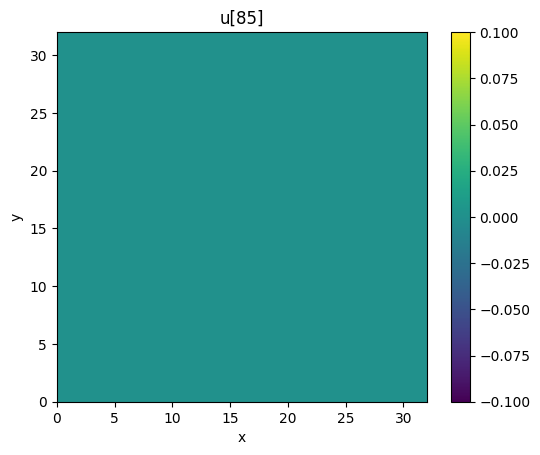

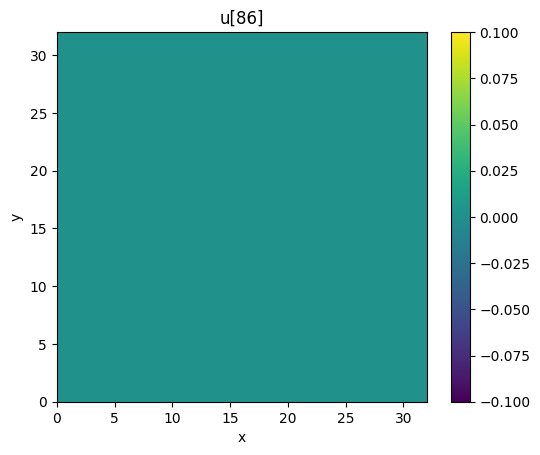

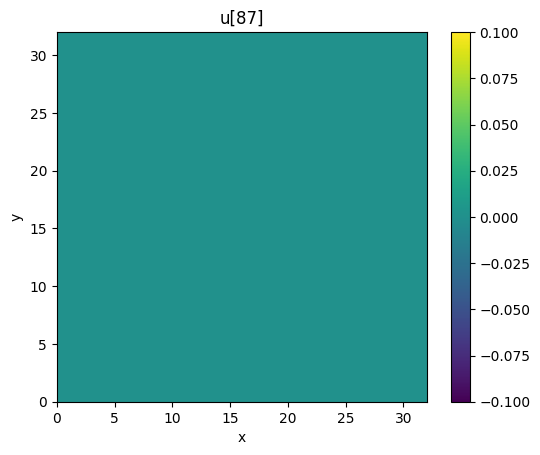

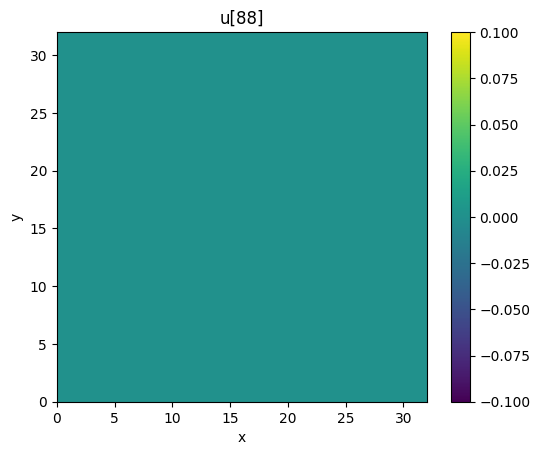

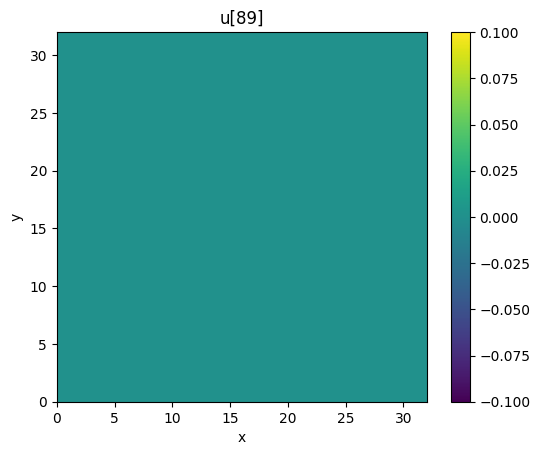

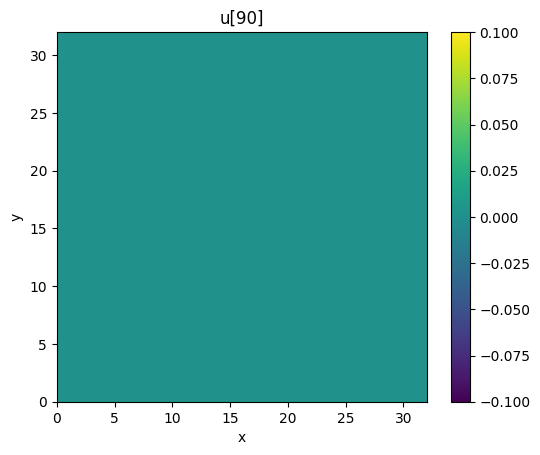

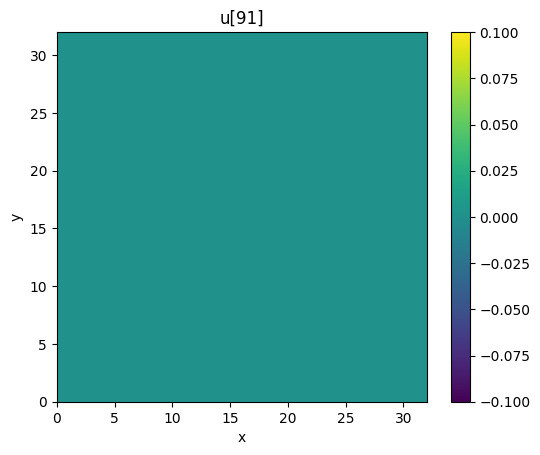

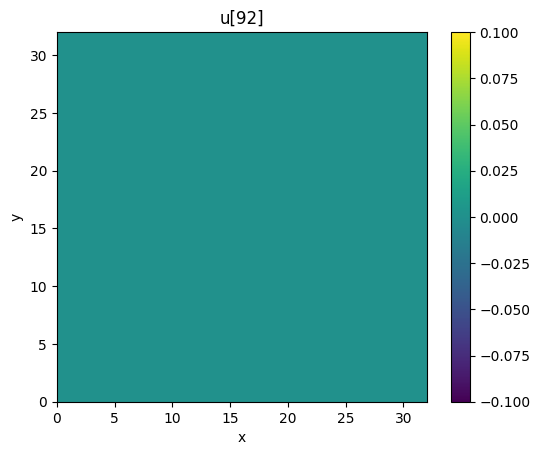

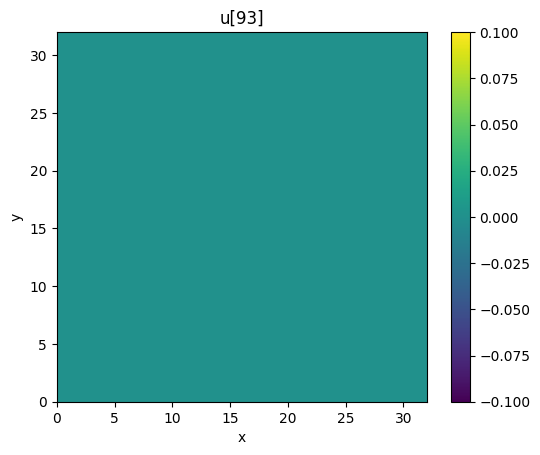

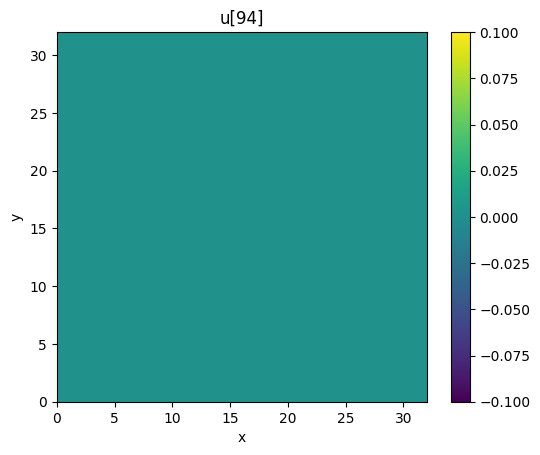

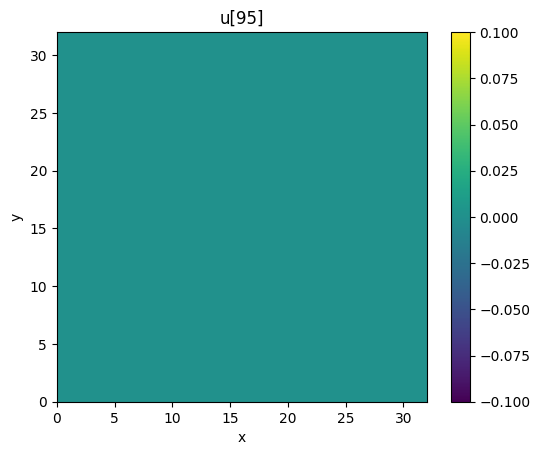

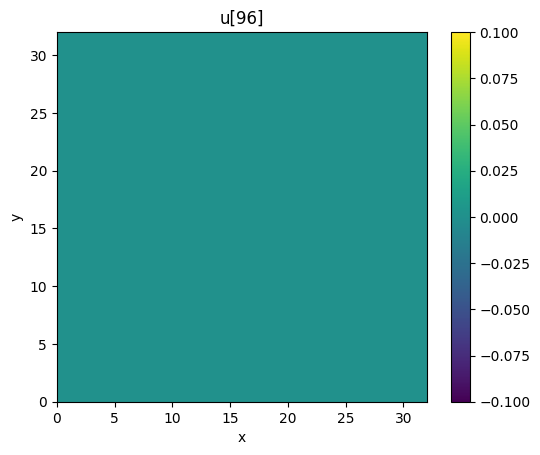

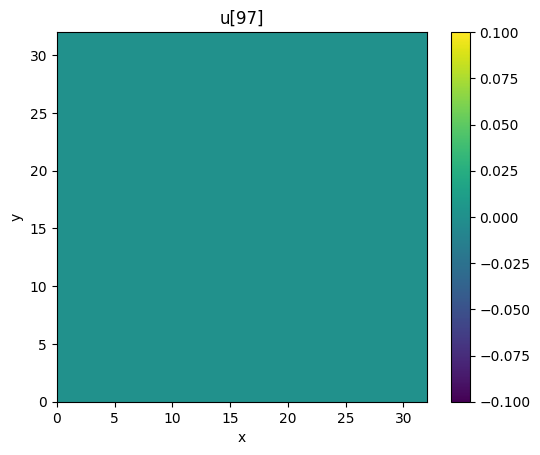

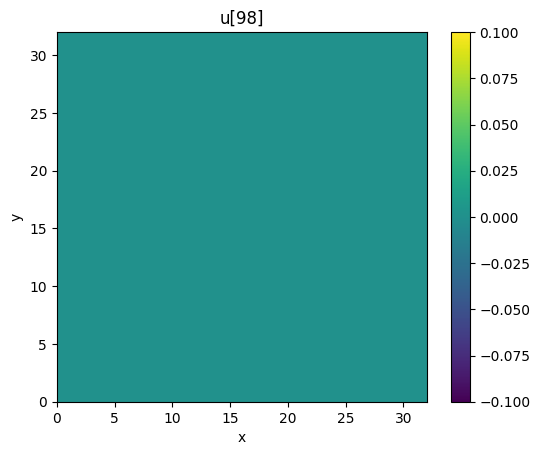

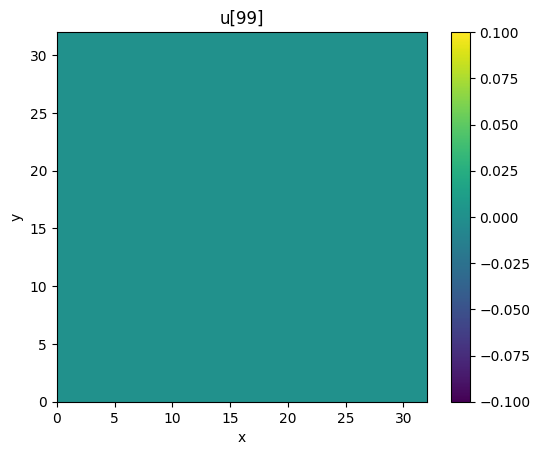

In [ ]:
# Upwind finite differences for advection equation

import numpy as np
import scipy

N = 32
bounds = jnp.array([0, N])
L = bounds[1] - bounds[0]
dx = L / N
x = np.linspace(bounds[0], bounds[1], N, endpoint = False)
y = np.linspace(bounds[0], bounds[1], N, endpoint = False)
X, Y = np.meshgrid(x, y)
v_x = 1
v_y = 4
d = 0 ## TODO: add diffusion coefficient
dt = 0.2

C = v_x * dt / dx + v_y * dt / dx
print(f"The Courant number is {C}. Stable if C <= 1.")

max_iter_time = 100

# Initialize solution: the grid of u(k, i, j)
u = np.zeros((max_iter_time, N, N))
u[0] = np.exp(- ((X - N / 2)**2 + (Y - N / 2)**2)/(N / 2))

# Set the initial condition
# u[0, N // 4 : 3 * N //4, N // 4 : 3 * N // 4] = 10
plot_data(u[0], title = "Initial Condition", show = True)

for k in range(max_iter_time - 1):
    # grad_vx = np.gradient(u[k])[1] * v_x
    # plot_data(grad_vx, title = "x gradient, centered", show = True)
    pad_x = np.pad(u[k], pad_width = ((0, 0), (1, 0))) # Dirichlet boundary conditions
    pad_y = np.pad(u[k], pad_width = ((1, 0), (0, 0)))
    grad_vx = (pad_x[:, 1:] - pad_x[:, :-1]) / dx
    # plot_data(grad_vx, title = "x gradient, upwind", show = True)
    grad_vy = (pad_y[1:, :] - pad_y[:-1, :]) / dx
    op = -dt * (grad_vx * v_x + grad_vy * v_y)
    lap_kernel = 1 / (dx ** 2) * np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    op += d * dt * scipy.signal.convolve2d(u[k], lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
    u[k + 1] = u[k] + op
    plot_data(data = u[k + 1], title = f"u[{k+1}]", show = True)
    # plot_data(data = np.exp(- (((X - dt * k * v_x) - N / 2)**2 + ((Y - dt * k * v_y) - N / 2)**2)/(N / 2)), title = "True solution", show = True)
    # plot_data(data = u[k + 1] - np.exp(- (((X - dt * k * v_x) - N / 2)**2 + ((Y - dt * k * v_y) - N / 2)**2)/(N / 2)), title = "Difference", show = True)

In [ ]:
#@title CNN
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# import jax
# from jax import numpy as jnp
import numpy as np
import tensorflow.keras as keras
import pandas as pd

In [ ]:
from matplotlib.font_manager import dataclasses
## https://www.tensorflow.org/tutorials/images/cnn

folder = "/content/drive/MyDrive/superUROP/2023-11-29"
N = 32
def description(i = None):
    if i is None:
        return f"diffusion_test5_32x32_newton_0.04"
    else:
        return f"diffusion_test5_32x32_newton_{i}_0.04"

"""
Load training/testing data from numpy file

Parameters:
* n_t : number of timesteps to load for each initial condition
* (i_start, i_stop) : load data with initial condition seeds in this range
* show : if True, displays the data as a plot
"""
def load_data(n_t, i_start, i_stop, description, show = False):
    n_t = 10 # train on each data from an train_initial condition, up to the first n_t timesteps

    # load first data i
    i = i_start
    data = np.load(f"{folder}/{description(i)}.npy")
    max_n_t = data.shape[0]
    initial = np.expand_dims(data[:min(n_t, max_n_t - 1), :, :], axis = -1)
    next = np.expand_dims(data[1 : min(n_t, max_n_t - 1) + 1, :, :], axis = -1)
    print(f"{initial.shape=}")
    if initial.shape[0] > 0:
        plot_data(initial[0, :, :, 0], show = show)
    i += 1

    while i < i_stop:
        data = np.load(f"{folder}/{description(i)}.npy")
        max_n_t = data.shape[0]
        initial_i = np.expand_dims(data[: min(n_t, max_n_t - 1), :, :], axis = -1)
        print(f"{i}: {initial.shape=}")
        next_i = np.expand_dims(data[1 : min(n_t, max_n_t - 1) + 1, :, :], axis = -1)
        initial = np.concatenate((initial, initial_i), axis = 0)
        next = np.concatenate((next, next_i), axis = 0)
        i += 1
    predict = initial - next
    return initial, predict, next

"""
Parameters:
* n_t : number of timesteps to load for each initial condition
* n_plot : number of initial conditions to plot
"""
def plot_first_j(data, n_t, n_plot = None, shape = (3, 3), title = "", dpi = 300, save = False):
    # N = data.shape[1]
    if n_plot is None:
        n_plot = data.shape[0] // n_t
    for j in range(n_plot): # for each initial condition
        print(f"plotting {j=}")
        fig, axs = plt.subplots(shape[0], shape[1], figsize=(2 * shape[1], 2 * shape[0]), dpi = dpi, constrained_layout=True)
        fig.suptitle(title)
        vmin = np.min(data[n_t * j : n_t * (j + 1), :, :, :])
        vmax = np.max(data[n_t * j : n_t * (j + 1), :, :, :])
        for i in range(shape[0]):
            for k in range(shape[1]):
                # axs[0].
                # ax = axs[0].subplot(shape[0], shape[1], i+1)
                # plt.xticks([])
                # plt.yticks([])
                # plt.grid(False)
                m = axs[i, k].pcolormesh(data[n_t * j + i * shape[1] + k, :, :, 0], vmin = vmin, vmax = vmax)
                # plt.colorbar(m)
                # The CIFAR labels happen to be arrays,
                # which is why you need the extra index
                axs[i, k].set_xlabel(i * shape[1] + k)
                axs[i, k].set_aspect('equal')
        fig.colorbar(m, ax=axs.ravel().tolist())
        if save:
            plt.savefig(f"{folder}/{description()}_plot{shape[0]}x{shape[1]}_{j}.png")
        plt.show()

def plot_first_25(data, title = "", dpi = 300, save = False, vmax = None, vmin = None):
    shape = (5, 5)
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(2 * shape[1], 2 * shape[0]), dpi = dpi, constrained_layout=True)
    fig.suptitle(title)
    if vmin is None:
        vmin = np.min(data[:shape[0] * shape[1], :, :, :])
    if vmax is None:
        vmax = np.max(data[:shape[0] * shape[1], :, :, :])
    for i in range(shape[0]):
        for k in range(shape[1]):
            m = axs[i, k].pcolormesh(data[i * shape[1] + k, :, :, 0], vmin = vmin, vmax = vmax)
            axs[i, k].set_xlabel(i * shape[1] + k)
            axs[i, k].set_aspect('equal')
    fig.colorbar(m, ax=axs.ravel().tolist())
    if save:
        plt.savefig(f"{folder}/{description()}_plot{shape[0]}x{shape[1]}.png")
    plt.show()


def load_train_test_data():
    train_range = range(0, 24)
    test_range = range(25, 30)
    n_t = 10
    train_initial, train_predict, train_next = load_data(n_t = 10, i_start = train_range.start, i_stop = train_range.stop, description = description, show = True)
    test_initial, test_predict, test_next = load_data(n_t = 10, i_start = test_range.start, i_stop = test_range.stop, description = description, show = True)
    print(train_initial.shape)
    plot_first_25(data = train_initial, title = "Training initial timestep", save = False)
    plot_first_25(data = train_next, title = "Training initial timestep", save = False)
    # plot_first(data = train_next, n_t = 10, n_plot = 5, shape = [2, 5], title = "Training next timestep", save = False)
    # plot_first(data = train_predict, n_t = 10, n_plot = 5, shape = [2, 5], title = "Training difference", save = False)
    return train_initial, train_predict, train_next, test_initial, test_predict, test_next
train_initial, train_predict, train_next, test_initial, test_predict, test_next = load_train_test_data()

initial.shape=(10, 32, 32, 1)


NameError: name 'plot_data' is not defined

In [ ]:
def plot_maes(train_initial, test_initial):
    maes = np.array([])
    for i in range(train_initial.shape[0]):
        diff = train_initial[i, :, :, :] - train_predict[i, :, :, :]
        mae = np.abs(diff).mean()
        maes = np.append(maes, mae)
        if i < 10:
            m = plt.pcolormesh(np.squeeze(diff))
            # m = plt.pcolormesh(train_initial[i, :, :, 0])
            plt.colorbar(m)
            plt.show()
            # m = plt.pcolormesh(train_predict[i + 1, :, :, 0] - train_initial[i, :, :, 0])
            # plt.colorbar(m)
            # plt.show()
    plt.plot(maes)
    print(f"average mae: {np.mean(maes)}")
    print(f"median mae: {np.median(maes)}")
plot_maes(train_initial, test_initial)

In [ ]:
from re import X
# https://stackoverflow.com/questions/42384602/implementing-skip-connections-in-keras
import tensorflow as tf
from tensorflow.keras import layers, models

def skip_net():
    input_net = layers.Input(shape = (N, N, 1))
    conv1 = layers.Convolution2D(32, (3, 3), activation = 'relu', padding = "same")(input_net)
    conv2 = layers.Convolution2D(64, (3, 3), activation = 'relu', padding = "same")(conv1)
    conv3 = layers.Convolution2D(32, (3, 3), activation = 'relu', padding = "same")(conv2)
    conv3 = layers.Concatenate()([conv2, conv3])
    conv4 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(conv3)
    conv4 = layers.Concatenate()([conv1, conv4])
    output_net = layers.Convolution2D(1, (3, 3), activation = 'linear', padding = "same")(conv4)
    model = models.Model(inputs = input_net, outputs = output_net)
    tf.keras.utils.plot_model(model, f"{folder}/skip_net_graph.png")
    print("make sure the output size is correct")
    return model

def skip_net_small(N = 32):
    input_net = layers.Input(shape = (N, N, 1))
    conv1 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(input_net)
    conv2 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(conv1)
    conv3 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(conv2)
    conv4 = layers.Concatenate()([conv1, conv3])
    conv5 = layers.Concatenate()([input_net, conv4])
    conv5 = layers.Convolution2D(1, (3, 3), activation = 'linear', padding = "same")(conv5)
    output_net = layers.Add()([input_net, conv5])
    model = models.Model(inputs = input_net, outputs = conv5)
    tf.keras.utils.plot_model(model, f"{folder}/skip_net_graph.png")
    print("plotted")
    return model

def create_model():
    model = skip_net_small()

    lr = 0.001
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='mean_squared_error',
                metrics=['mae'])
    print(f"Learning rate: {lr}")

    # plot_data(train_initial[2, :, :, 0], show = True)
    # plot_data(train_predict[2, :, :, 0], show = True)

    hist_csv_file = f'{folder}/{description()}_history.csv'
    with open(hist_csv_file, mode='w') as f:
        pd.DataFrame().to_csv(f)
    return model, hist_csv_file

# model, hist_csv_file = create_model()

In [ ]:
def train_model(lr):
    keras.backend.set_value(model.optimizer.learning_rate, lr)
    history = model.fit(train_initial, train_next, epochs=1, batch_size = 100)
    model.save(f"{folder}/{description()}_model")
    # return history.history['mae']
    return history.history

def plot_history_mae(history): #history):
    plt.plot(history['mae'], label='mean absolute error')
    # plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.yscale('log')
    # plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.savefig(f"{folder}/{description}_loss")
    plt.show()
    train_loss, train_acc = model.evaluate(train_initial, train_next, verbose=2)
    test_loss, test_acc = model.evaluate(test_initial, test_next, verbose=2)
    print(f"{train_loss=}, {train_acc=}, {test_loss=}, {test_acc=}")

run = False
if run:
        # Print initial loss/accuracy
        starting_loss, starting_acc = model.evaluate(train_initial, train_next, verbose=2)
        print(f"{starting_loss=}, {starting_acc=}")

        ## Read history dataframe from file; will append new history data if existing already
        hist_df = pd.read_csv(hist_csv_file)
        if hist_df.empty:
            history = {}
        else:
            history = hist_df.to_dict('list')
            print(history)

        lr = 0.0005
        for i in range(100):
            history_i = train_model(lr = lr)
            for metric in history_i:
                if metric in history:
                    history[metric] = np.append(history[metric], history_i[metric])
                else:
                    history[metric] = history_i[metric]
            # print(history)
            with open(hist_csv_file, mode='w') as f:
                pd.DataFrame.from_dict(history).to_csv(f, index = False)
            # np.save(file = hist_csv_file, arr = history_maes)
        # print(history)

        plot_history_mae(history)


In [ ]:
hist_df = pd.read_csv(hist_csv_file)
print(hist_df)
history = hist_df.to_dict('list')
print(history)

In [ ]:
#@title Load Model

#@title CNN
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# import jax
# from jax import numpy as jnp
import numpy as np
import tensorflow.keras as keras

folder = "/content/drive/MyDrive/superUROP/2023-11-29"
def description(i = None):
    if i is None:
        return f"diffusion_test5_32x32_newton_0.04"
    else:
        return f"diffusion_test5_32x32_newton_{i}_0.04"

model = keras.models.load_model(f"{folder}/{description()}_model")
N = 32

# ## Plot first 25 inputs
# def plot_results(data, title = "", n = 3, vmax = None, vmin = None):
#     plt.figure(figsize=(10,10), dpi = 200)
#     plt.title("HELLO")
#     if vmax is None:
#         vmax = np.max(data[:n**2])
#     if vmin is None:
#         vmin = np.min(data[:n**2])
#     for i in range(n**2):
#         plt.subplot(n, n, i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         m = plt.pcolormesh(data[i, :, :, 0], vmin = vmin, vmax = vmax)
#         plt.colorbar(m)
#         plt.title(title)
#         # The CIFAR labels happen to be arrays,
#         # which is why you need the extra index
#         plt.xlabel(i)
#     plt.savefig(f"{folder}/{description()}_{title}.png")
#     plt.show()

# train_initial, train_predict, train_next, test_initial, test_predict, test_next = load_train_test_data()


train_loss, train_acc = model.evaluate(train_initial, train_next, verbose=2)
def plot_test_results(model, test_initial, test_next):
    test_loss, test_acc = model.evaluate(test_initial, test_next, verbose=2)
    predicted = model.predict(test_initial)
    vmax = np.max([predicted, test_next])
    vmin = np.min([predicted, test_next])

    plot_first_25(predicted, title = "Predicted", vmax = vmax, vmin = vmin)
    plot_first_25(test_next, title = "Target", vmax = vmax, vmin = vmin)
    plot_first_25(predicted - test_next, title = "Difference")

plot_test_results(model, test_initial, test_next)
# predicted = model.predict(initial)
# plot_results(predicted, title = "Predicted")
# plot_results(predict, title = "Actual")
# plot_results(predicted - predict, title = "Difference")

In [ ]:
## Test "out of distribution" data

folder = "/content/drive/MyDrive/superUROP/2023-11-29"
N = 32
def description4(i = None):
    if i is None:
        return f"diffusion_test4_32x32_newton_0.04"
    else:
        return f"diffusion_test4_32x32_newton_{i}_0.04"

test4_range = range(0, 7)
n_t = 10
test4_initial, test4_predict, test4_next = load_data(n_t = n_t, i_start = test4_range.start, i_stop = test4_range.stop, description = description4, show = True)
# plot_first_25(data = test4_initial, title = "Training initial timestep", save = False)
# plot_first_25(data = test4_next, title = "Training next timestep", save = False)

plot_test_results(model, test4_initial, test4_next)


In [ ]:
import time

dt = 0.04
def compare_time_iters(ic_test = 5):
    cnn_times = []
    regular_times = []
    cnn_iters = []
    regular_iters = []

    seeds = np.arange(start = 0, stop = 10)
    max_iter_time = 5
    newton_max_iter = 15
    ic_test = 4
    N = 32
    for i in seeds:
        print(i)
        start = time.time()
        u, anim, n_iters = newton_solver(seed = i, save_mp4 = True, method = "newton", initializer = lambda x: model.predict(x), dt = dt, ic_test = ic_test, max_iter_time = max_iter_time, newton_max_iter = newton_max_iter, N = N)
        end = time.time()
        cnn_times.append(end - start)
        print(f"{n_iters=}")
        cnn_iters.append(n_iters)
        print(f"{cnn_iters=}")

        start = time.time()
        u, anim, n_iters = newton_solver(seed = i, save_mp4 = True, method = "newton", dt = dt, ic_test = ic_test, max_iter_time = max_iter_time, newton_max_iter = newton_max_iter, N = N)
        end = time.time()
        regular_times.append(end - start)
        regular_iters.append(n_iters)

        print(f"{regular_iters=}")
        print(f"{cnn_iters=}")
        print(f"{regular_times=}")
        print(f"{cnn_times=}")
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_regular_iters", arr = regular_iters)
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_cnn_iters", arr = cnn_iters)
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_regular_times", arr = regular_times)
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_cnn_times", arr = cnn_times)
        ## Plot
        plt.figure()
        plt.scatter(seeds[:len(regular_times)], regular_times, label = "regular times", color = 'red', marker = 'x')
        plt.scatter(seeds[:len(cnn_times)], cnn_times, label = "cnn times", color = 'blue', marker = 'x')
        plt.legend()
        plt.ylim(bottom = 0)
        plt.title("Time Comparison (seconds)")
        plt.show()

        plt.scatter(seeds[:len(regular_iters)], [np.average(it_t[:-1]) for it_t in regular_iters], label = "regular iterations", color = 'red', marker='x')
        plt.scatter(seeds[:len(cnn_iters)], [np.average(it_t[:-1]) for it_t in cnn_iters], label = "cnn iterations", color = 'blue', marker='x')
        plt.legend()
        plt.ylim(bottom = 0)
        plt.title("Average number of Iterations Comparison")
        plt.show()

    # ## Plot
    # plt.figure()
    # plt.scatter(seeds[:len(regular_times)], regular_times, label = "regular times", color = 'red', marker = 'x')
    # plt.scatter(seeds[:len(cnn_times)], cnn_times, label = "cnn times", color = 'blue', marker = 'x')
    # plt.legend()
    # plt.ylim(bottom = 0)
    # plt.title("Time Comparison (seconds)")
    # plt.show()

    # plt.scatter(seeds[:len(regular_iters)], [np.average(it_t[:-1]) for it_t in regular_iters], label = "regular iterations", color = 'red', marker='x')
    # plt.scatter(seeds[:len(cnn_iters)], [np.average(it_t[:-1]) for it_t in cnn_iters], label = "cnn iterations", color = 'blue', marker='x')
    # plt.legend()
    # plt.ylim(bottom = 0)
    # plt.title("Average number of Iterations Comparison")
    # return cnn_times, regular_times, cnn_iters, regular_iters, seeds

cnn_times, regular_times, cnn_iters, regular_iters, seeds = compare_time_iters()

In [ ]:
seeds = np.arange(start = 24, stop = 34)
regular_iters=[np.array([25.]), np.array([25.]), np.array([6., 6., 6., 6., 5., 5., 4., 4., 3., 3.]), np.array([ 5.,  6.,  6., 12.,  7.,  5.,  4.,  4.,  5.,  5.]), np.array([6., 6., 6., 6., 5., 5., 4., 4., 3., 3.]), np.array([6., 7., 6., 6., 6., 6., 5., 4., 3., 3.]), np.array([ 9.,  8., 18.,  7.,  6.,  7., 25.]), np.array([7., 5., 6., 6., 6., 5., 5., 4., 5., 6.]), np.array([ 6.,  7.,  6., 25.]), np.array([ 7., 25.])]
cnn_iters=[np.array([6., 6., 6., 5., 6., 6., 5., 3., 3., 3.]), np.array([6., 4., 5., 5., 6., 6., 4., 3., 3., 3.]), np.array([6., 5., 6., 5., 4., 4., 3., 3., 3., 3.]), np.array([ 5.,  5.,  6., 12.,  5.,  4.,  4.,  4.,  4.,  7.]), np.array([5., 5., 5., 5., 5., 4., 3., 3., 3., 3.]), np.array([4., 6., 5., 5., 6., 6., 4., 3., 3., 3.]), np.array([6., 6., 6., 6., 6., 8., 6., 7., 6., 4.]), np.array([5., 5., 6., 6., 5., 5., 4., 4., 4., 5.]), np.array([6., 6., 5., 6., 6., 6., 6., 7., 4., 3.]), np.array([6., 5., 5., 6., 5., 5., 5., 4., 7., 5.])]
regular_times=[41.068368673324585, 43.73337006568909, 92.15044736862183, 111.36302208900452, 93.6173186302185, 103.7004086971283, 149.43357825279236, 109.86091566085815, 82.07162308692932, 59.671379804611206]
cnn_times=[102.0141053199768, 95.23440480232239, 91.83798122406006, 115.2849760055542, 91.77917790412903, 99.30102181434631, 128.84389281272888, 112.48367381095886, 122.64945554733276, 120.42994666099548]

plt.figure()
plt.scatter(seeds[:len(regular_times)], [regular_times[i] / regular_iters[i].shape[0] for i in range(len(regular_iters))], label = "regular times", color = 'red', marker = 'x')
plt.scatter(seeds[:len(cnn_times)], [cnn_times[i] / cnn_iters[i].shape[0] for i in range(len(cnn_iters))], label = "cnn times", color = 'blue', marker = 'x')

# plt.scatter(seeds[:len(cnn_times)], cnn_times, label = "cnn times", color = 'blue', marker = 'x')
plt.legend()
plt.ylim(bottom = 0)
plt.ylabel("Initial Seed")
plt.title("Time per iteration Comparison (seconds)")
plt.show()

plt.scatter(seeds[:len(regular_iters)], [np.average(it_t) if 25 not in it_t else None for it_t in regular_iters], label = "regular iterations", color = 'red', marker='x')
plt.scatter(seeds[:len(cnn_iters)], [np.average(it_t) if 25 not in it_t else None for it_t in cnn_iters], label = "cnn iterations", color = 'blue', marker='x')
plt.legend()
plt.ylim(bottom = 0)
plt.ylabel("Initial Seed")
plt.title("Average number of Iterations Comparison")
plt.show()


In [ ]:
from scipy.interpolate import RegularGridInterpolator

# Do the calculation here
def newton_solver2(seed, save_mp4 = True, method = "newton", initializer = None, dt = 0.02, tol = 1e-5, ic_test = 4,
                  max_iter_time = 2, newton_max_iter = 10):
    bounds = np.array([0, 2 * jnp.pi])
    L = bounds[1] - bounds[0]
    N = 32
    dx = L / N
    bc = "dirichlet"
    bc_test = "dirichlet"
    key = jax.random.PRNGKey(seed)
    plot_calculation = False
    plot_newton = False

    animate_newton = False # Whether to animate the Newton iterations
    # newton_max_iter = 100 # maximum number of iterations that the newton solver will run for

    # u, x, y = initialize(bounds, N, max_iter_time, dx, ic_test = ic_test, bc_test = bc_test, key = key)
    N_in = 32
    N_out = 64
    # interp = RegularGridInterpolator((x, y), np.asarray(u[0]), # np.asarray bc jax doesnt work
    #                                 bounds_error=False, fill_value=None, method = 'nearest')
    # plot_data(u[0], show = True)
    x_in = np.linspace(bounds[0], bounds[1], N_in)
    y_in = np.linspace(bounds[0], bounds[1], N_in)
    X_in, Y_in = np.meshgrid(x_in, y_in, indexing = 'ij')
    # Interpolate data
    # x_out = np.linspace(bounds[0], bounds[1], N_out)
    # y_out = np.linspace(bounds[0], bounds[1], N_out)
    # X_out, Y_out = np.meshgrid(x_out, y_out, indexing='ij')

    u_out, x_out, y_out = initialize(bounds, N_out, max_iter_time, dx, ic_test = ic_test, bc_test = bc_test, key = key)
    X_out, Y_out = np.meshgrid(x_out, y_out, indexing='ij')
    # u_out = u_out.at[0].set(interp((X_out, Y_out), method = 'linear'))
    # plot_data(u_out[0], show = True)

    def cnn_initializer(x0):
        x0 = x0.reshape(N_out, N_out)
        plot_data(x0, title = 'x0', show = True)
        downsample = RegularGridInterpolator((x_out, y_out), np.asarray(x0), # np.asarray bc jax doesnt work
                                    bounds_error=False, fill_value=None, method = 'linear')
        downsampled_x0 = downsample((X_in, Y_in))
        plot_data(downsampled_x0, title = 'downsampled', show = True)
        downsampled_x0 = np.expand_dims(downsampled_x0, axis = (0, -1))
        print(downsampled_x0.shape)
        cnn_prediction = np.squeeze(model.predict(downsampled_x0))
        print(cnn_prediction.shape)
        plot_data(cnn_prediction, title = 'cnn_prediction', show = True)
        upsample = RegularGridInterpolator((x_in, y_in), np.asarray(cnn_prediction - np.squeeze(downsampled_x0)), # np.asarray bc jax doesnt work
                                    bounds_error=False, fill_value=None, method = 'linear')
        output = upsample((X_out, Y_out), method = 'linear') + x0
        plot_data(output, title = 'output', show = True)
        return output.reshape(N_out, N_out)

    def cnn_initializer2(x0):
        print(x0.shape)
        plot_data(model.predict(x0).reshape(N_out, N_out), show = True)
        return model.predict(x0)
    cnn_u_out, cnn_n_iters = calculate(u_out, dt = dt, dx = dx, bc = bc, method = method, initializer = cnn_initializer2, tol = tol, newton_max_iter = newton_max_iter, plot = plot_calculation, plot_newton = plot_newton)
    print(f"{cnn_n_iters}")
    u_out, n_iters = calculate(u_out, dt = dt, dx = dx, bc = bc, method = method, initializer = initializer, tol = tol, newton_max_iter = newton_max_iter, plot = plot_calculation, plot_newton = plot_newton)
    print(f"{n_iters}")

    def animate(k, u, x = None, y = None):
        plot_data(u[k], title = f"Temperature at t = {k * dt:.3f} unit time", X = x_out, Y = y_out, vmin = jnp.min(u), vmax = jnp.max(u))

    folder = "drive/MyDrive/superUROP/2023-11-29"
    test_name = f"diffusion_test{ic_test}_{N_out}x{N_out}_{method}_{seed}_{dt}"
    filename = f"{folder}/{test_name}"
    jnp.save(filename, u_out)
    if save_mp4:
        anim = animation.FuncAnimation(plt.figure(), lambda k: animate(k, u_out), frames=u_out.shape[0], repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 10)
        anim.save(f"{filename}.mp4", writer = FFwriter, dpi = 300)
    else:
        anim = "No animation"

    return cnn_u_out, cnn_n_iters, u_out, n_iters

cnn_u_out_list = []
cnn_n_iters_list = []
u_out_list = []
n_iters_list = []
cnn_u_out, cnn_n_iters, u_out, n_iters = newton_solver2(seed = 0, ic_test = 5)
cnn_u_out_list.append(cnn_u_out)
cnn_n_iters_list.append(cnn_n_iters)
n_iters_list.append(u_out)
cnn_u_out_list.append(n_iters)
cnn_u_out, cnn_n_iters, u_out, n_iters = newton_solver2(seed = 1, ic_test = 5)
cnn_u_out, cnn_n_iters, u_out, n_iters = newton_solver2(seed = 2, ic_test = 5)

- use MAE for training
- can try wrapping boundary conditions around
- "converging" is different from amount of time that it takes
- parareal -- parallelize PDEs over time?
    - usually people will be conservative with choices of dt (they will choose dt such that it will definitely converge)
- try testing NN (trained on dt and predicting 4dt) and then predict only every 4 vs regular iterations on dt run for 4 times (so we will "multiply" the number of iters by 4 ish)
    - will need to retrain NN
    - "multigrid/multitime"

In [ ]:
def test_times():
    import time
    cnn_times = []
    regular_times = []

    cnn_iters = []
    regular_iters = []

    dts = np.linspace(0.003, 0.007, 5)
    for dt in dts:
        print(dt)

        start = time.time()
        u, anim, n_iters = newton_solver(seed = 4, save_mp4 = True, method = "newton", initializer = lambda x: x - model.predict(x), dt = dt)
        end = time.time()
        cnn_times.append(end - start)
        cnn_iters.append(n_iters)

        start = time.time()
        u, anim, n_iters = newton_solver(seed = 4, save_mp4 = True, method = "newton", dt = dt)
        end = time.time()
        regular_times.append(end - start)
        regular_iters.append(n_iters)

    print(f"{regular_iters=}")
    print(f"{cnn_iters=}")
    print(f"{regular_times=}")
    print(f"{cnn_times=}")

    ## Plot
    plt.plot(dts[:len(regular_times)], regular_times, label = "regular times")
    plt.plot(dts[:len(cnn_times)], cnn_times, label = "cnn times")
    plt.legend()
    plt.ylim(bottom = 0)
    plt.title("Time Comparison (seconds)")
    plt.show()

    print(regular_iters)
    print(cnn_iters)

    plt.plot(dts[:len(cnn_iters)], [np.average(it_t[:-1]) for it_t in cnn_iters], label = "cnn iterations")
    plt.plot(dts[:len(regular_iters)], [np.average(it_t[:-1]) for it_t in regular_iters], label = "regular iterations")
    plt.legend()
    plt.ylim(bottom = 0)
    plt.title("Average number of Iterations Comparison")



- Isotropic nonlinear diffusion -- use $\partial u/\partial t = \nabla \cdot (d(v, c) \nabla c)$ where $d$ is a diffusion coefficient depending on $v$ and $c$
- Here let $d$ not depend on $x$ except $u$ depends on $x$. Set $d = e^{-1/|\nabla c|^2}$, so that when the gradient of c is higher, diffuse more and when the gradient is low, diffuse less (e.g. image processing where you smooth out large sections of the same color and preserve edges)
- Instead of call to cg, call to newton's method
- Implement standard Newton's method in higher dimensions https://jax.quantecon.org/newtons_method.html

To solve iteratively, want $u_{n+1}$ to satisfy (here d is a diffusion coefficient depending on the gradient of c) $$u_{n+1} = u_n + dt  \nabla \cdot (d(\nabla u_{n+1}) \nabla u_{n+1})$$ by taking $du/dt = (u_{n+1} - u_{n})/dt$. Then previously we would pull out the $d$ and make it linear and solve using cg, but we can't because d depends on c. So here, we set $$F(u) = -(u-u_n) + dt \nabla \cdot (d(\nabla u) \cdot \nabla u),$$ or $$F(u) = u_n - u + dt \nabla \cdot (d(\nabla u) \cdot \nabla u),$$ where $u_{n+1}$ should satisfy $F(u_{n+1}) = 0$. We can solve this using Newton's method. Here $F: \mathbb{R}^{N \times N} \to \mathbb{R}^{N \times N}$.